# Температура сплава на этапе обработки стали

Чтобы оптимизировать производственные расходы, металлургическому комбинату требуется уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Задача состоит в  построении модели, которая будет её предсказывать. Разработанная модель будет использована для имитации технологического процесса.

Этап обработки стали состоит из нескольких циклов:
сначала расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами,
затем измеряют температуру стали и производят её химический анализ.
Потом в нее добавляют легирующие материалы и продувают сплав инертным газом, после
чего снова измеряют температуру и производят её химический анализ.
Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

    
<b>Цель проекта:</b> построение модели предсказания температуры сплава на этапе обработки стали, в качестве признаков используя данные об объеме сыпучих и проволочных материалов, объемов подаваемого газа, мощности электродов, времени нагрева и начальной температуры стали.

План работы:

[1 Загрузка данных](#section1)

[2 Исследовательский анализ и предобработка данных](#section2)

[3 Объединение данных](#section3)

[4 Исследовательский анализ и предобработка данных объединенного датафрейма](#section4)

[5 Подготовка данных](#section5)

[6 Обучение моделей машинного обучения](#section6)

[7 Выбор лучшей модели](#section7)

[8 Общий вывод и рекомендации заказчику](#section8)



<a id='section1'></a>
##  Загрузка данных

Импортируем библиотеки.

In [1]:
!pip install phik -q

In [2]:
!pip install catboost -q

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
import os
import time
import lightgbm as  lgb

from matplotlib import rcParams
from scipy import stats as st

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler
)

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor

from sklearn.feature_selection import SelectKBest, f_regression

In [4]:
start = time.perf_counter()#счетчик времени работы программы

Загружаем данные об электродах.

In [5]:
try:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')
except:
    data_arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')

In [6]:
display(data_arc.head())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Данные загрузились корректно.

Загружаем данные о подаче сыпучих материалов.

In [7]:
try:
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
except:
    data_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')

In [8]:
display(data_bulk.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Данные загрузились корректно, но содержат много пропусков.

Загружаем данные о подаче сыпучих материалов (время).

In [9]:
try:
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
except:
    data_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')

In [10]:
display(data_bulk_time.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Данные загрузились корректно, но тоже содержат много пропусков.

Загружаем данные о продувке сплава газом.

In [11]:
try:
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
except:
    data_gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')

In [12]:
display(data_gas.head())

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Здесь все выглядит корректно.

Загружаем результаты измерения температуры.

In [13]:
try:
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
except:
    data_temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')

In [14]:
display(data_temp.head())

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Данные загружены корректно.

Загружаем данные о проволочных материалах (объем).

In [15]:
try:
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
except:
    data_wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')

In [16]:
display(data_wire.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Данные загружены корректно, но содержат много пропусков.

Загружаем данные о проволочных материалах (время).

In [17]:
try:
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
except:
    data_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

In [18]:
display(data_wire_time.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Здесь также загрузка прошла корректно, но видим много пропусков.

Итого, все данные загружены, теперь исследуем их более тщательно.

<a id='section2'></a>
##  Исследовательский анализ и предобработка данных

### Данные об электродах

Общая информация о датафрейме:

In [19]:
data_arc.info()
display(f'Дубликатов {data_arc.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


'Дубликатов 0'

Таблица содержит 14876 значений, пропусков нет, полных дубликатов нет.

Прежде всего переименуем столбцы на латиницу и сделаем их все со строчной буквы для единообразия.

In [20]:
data_arc=data_arc.rename(columns={'Начало нагрева дугой': 'heat_start',
                                  'Конец нагрева дугой':'heat_end',
                                  'Активная мощность':'power_act',
                                  'Реактивная мощность':'power_react'})

In [21]:
display(data_arc.head())

,key,heat_start,heat_end,power_act,power_react
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Переименование прошло корректно.

Теперь заметим, что начало и конец нагрева имеют строковый тип, хотя обозначают время. Поменяем тип этих переменных на datetime.

In [22]:
data_arc['heat_start']=pd.to_datetime(data_arc['heat_start'])
data_arc['heat_end']=pd.to_datetime(data_arc['heat_end'])

Посмотрим, какие значения принимают ключи (номера партии).

In [23]:
print(data_arc['key'].nunique())
data_arc['key'].unique()

3214


array([   1,    2,    3, ..., 3239, 3240, 3241])

Всего 3214 ключей.

Проверим корректность временных переменных.

Построим графики временных рядов, на которых отобразим номер партии и время начала и окончания нагрева дугой.

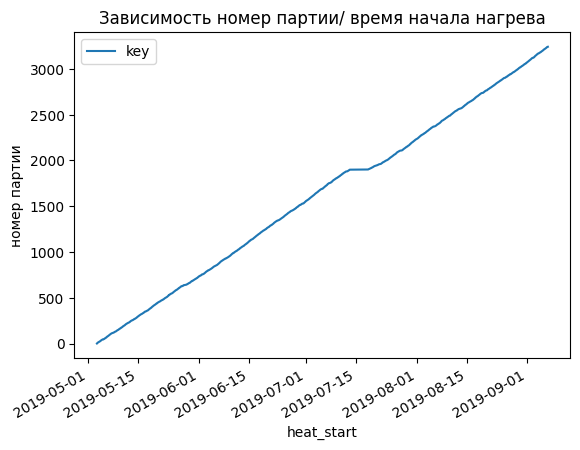

In [24]:
data_arc.plot(x='heat_start',y='key')

plt.title('Зависимость номер партии/ время начала нагрева')
plt.ylabel('номер партии')
plt.show()

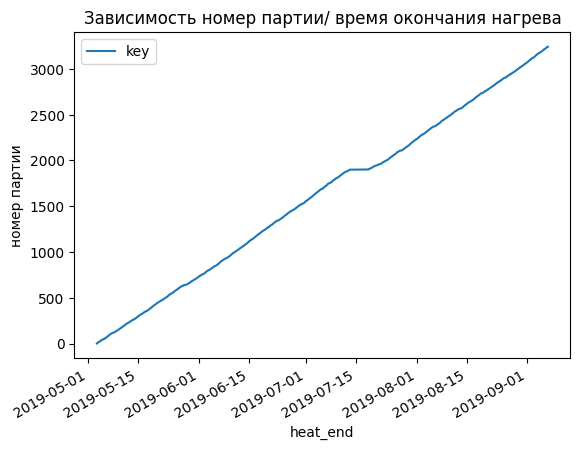

In [25]:
data_arc.plot(x='heat_end',y='key')

plt.title('Зависимость номер партии/ время окончания нагрева')
plt.ylabel('номер партии')
plt.show()

Даты выглядят правдоподобно, номер партии монотонно увеличивается с номером ключа, за исключением небольшого периода вокруг 15.07.2019.

Выведем неделю вокруг этой даты.

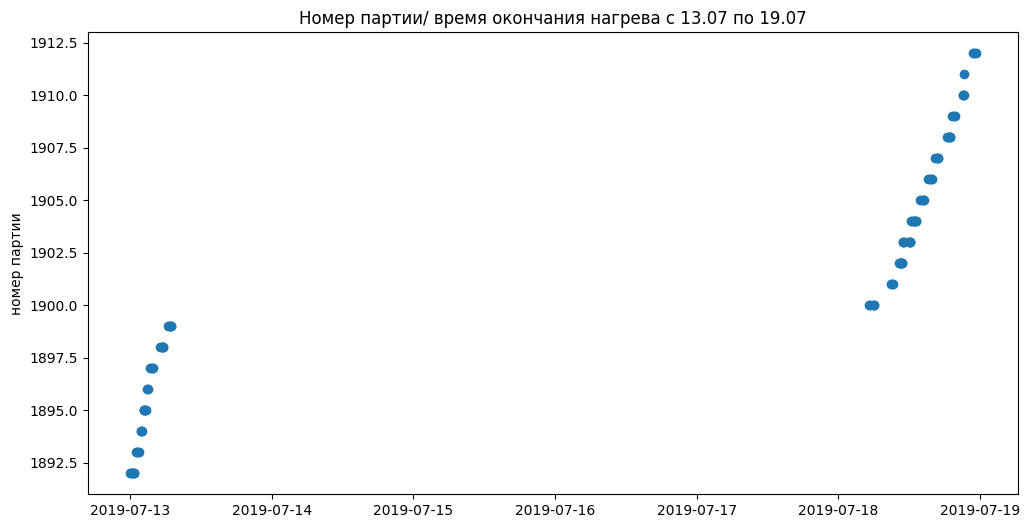

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter (data = data_arc[(data_arc['heat_end']>'2019-07-13') & (data_arc['heat_end']<'2019-07-19')], x = 'heat_end', y = 'key')

plt.title('Номер партии/ время окончания нагрева с 13.07 по 19.07')
plt.ylabel('номер партии')
plt.show()

Похоже, в этот период нагрев не проводился.

Выведем строки датафрейма с датой от 14.07 по 18.07.

In [27]:
display(data_arc[(data_arc['heat_end']>'2019-07-14') & (data_arc['heat_end']<'2019-07-18')])
display(data_arc[(data_arc['heat_start']>'2019-07-14') & (data_arc['heat_start']<'2019-07-18')])

,key,heat_start,heat_end,power_act,power_react


,key,heat_start,heat_end,power_act,power_react


Действительно, эти строки пусты.

Посмотрим, как выглядит распределение активной мощности.

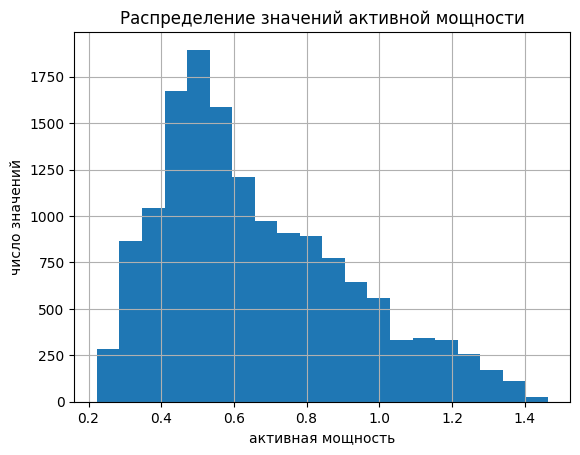

In [28]:
data_arc['power_act'].hist(bins=20)

plt.title('Распределение значений активной мощности')
plt.xlabel('активная мощность')
plt.ylabel('число значений')
plt.show()

Описательные статистики активной мощности:

In [29]:
display(data_arc['power_act'].describe())

,power_act
count,14876.000000
mean,0.662752
std,0.258885
min,0.223120
25%,0.467115
50%,0.599587
75%,0.830070
max,1.463773


Итак, активная мощность принимает значения примерно от 0.2 до 1.5, среднее значение 0.66, медиана 0.6, стандартное отклонение 0.26.

Распределение по виду больше похоже на распределение Пуассона, чем на нормальное.

Теперь рассмотрим реактивную мощность.

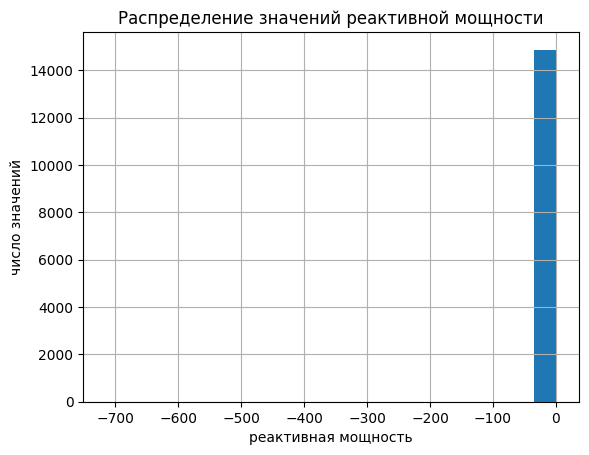

In [30]:
data_arc['power_react'].hist(bins=20)

plt.title('Распределение значений реактивной мощности')
plt.xlabel('реактивная мощность')
plt.ylabel('число значений')
plt.show()

Судя по гистограмме, есть какой-то сильный выброс - очень маленькое отрицательное значение.

Выведем описательные статистики, чтобы найти этот выброс.

In [31]:
display(data_arc['power_react'].describe())

,power_react
count,14876.000000
mean,0.438986
std,5.873485
min,-715.479924
25%,0.337175
50%,0.441639
75%,0.608201
max,1.270284


Выброс принимает значение -715.48.

Поскольку в таблице почти 15 тысяч строк, мы можем удалить одно значение без потери важной информации.

In [32]:
data_arc=data_arc[data_arc['power_react']>0]#оставляем только положительные значения мощности

Теперь гистограмма принимает нормальный вид:

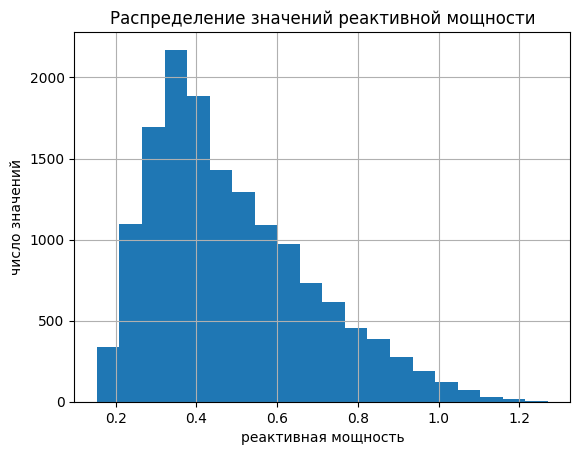

In [33]:
data_arc['power_react'].hist(bins=20)

plt.title('Распределение значений реактивной мощности')
plt.xlabel('реактивная мощность')
plt.ylabel('число значений')
plt.show()

Описательные статистики:

In [34]:
display(data_arc['power_react'].describe())

,power_react
count,14875.000000
mean,0.487115
std,0.197612
min,0.153777
25%,0.337190
50%,0.441665
75%,0.608223
max,1.270284


Реактивная мощность принимает значения от 0.15 до 1.27, среднее значение 0.49, медиана 0.44, стандартное отклонение 0.2.

Распределение также похоже на распределение Пуассона.

### Данные об объеме подачи сыпучих материалов

Общая информация о датафрейме:

In [35]:
data_bulk.info()
display(f'Дубликатов {data_arc.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


'Дубликатов 0'

Таблица содержит 3129 строк, но очень много пропусков.

Полных дубликатов нет.

Выведем долю пропущенных значений в процентах для каждого столбца.

In [36]:
data_bulk.isna().mean()*100

,0
key,0.000000
Bulk 1,91.946309
Bulk 2,99.296900
Bulk 3,58.517098
Bulk 4,67.593480
Bulk 5,97.539150
Bulk 6,81.591563
Bulk 7,99.201023
Bulk 8,99.968041
Bulk 9,99.392777


Из всех столбцов только Bulk 3, Bulk4, Bulk 12, Bulk 14 и Bulk 15 имеют меньше 80% пропусков.

Приведем названия столбцов к нижнему регистру.

In [37]:
data_bulk.columns = [x.lower() for x in data_bulk.columns]

In [38]:
display(data_bulk.head())

,key,bulk 1,bulk 2,bulk 3,bulk 4,bulk 5,bulk 6,bulk 7,bulk 8,bulk 9,bulk 10,bulk 11,bulk 12,bulk 13,bulk 14,bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Все пропуски в таблице заменим нулями.

In [39]:
for s in data_bulk.columns:
    data_bulk[s] = data_bulk[s].fillna(0)

In [40]:
display(data_bulk.head())

,key,bulk 1,bulk 2,bulk 3,bulk 4,bulk 5,bulk 6,bulk 7,bulk 8,bulk 9,bulk 10,bulk 11,bulk 12,bulk 13,bulk 14,bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [41]:
data_bulk.isna().sum()

,0
key,0
bulk 1,0
bulk 2,0
bulk 3,0
bulk 4,0
bulk 5,0
bulk 6,0
bulk 7,0
bulk 8,0
bulk 9,0


Теперь пропусков в таблице нет.

Построим гистограммы для всех столбцов датафрейма и выведем описательные статистики.

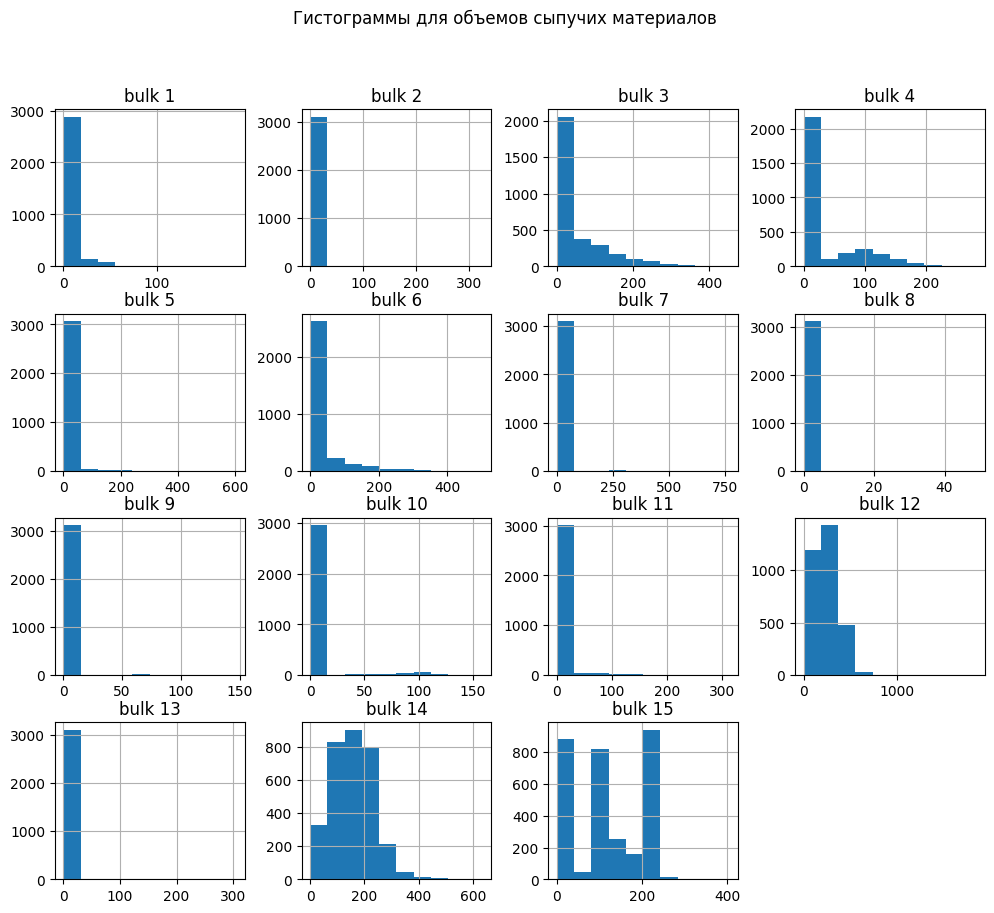

In [42]:
data_bulk.drop('key',axis=1).hist(figsize=(12,10))

plt.suptitle('Гистограммы для объемов сыпучих материалов')
plt.show()

In [43]:
data_bulk.describe()

,key,bulk 1,bulk 2,bulk 3,bulk 4,bulk 5,bulk 6,bulk 7,bulk 8,bulk 9,bulk 10,bulk 11,bulk 12,bulk 13,bulk 14,bulk 15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Только распределение bulk 14 похоже на нормальное, но надо иметь ввиду, что мы добавили очень много нулей в таблицу, что сильно исказило исходные распределения.

### Данные о времени подачи сыпучих материалов

Общая информация о датафрейме.

In [44]:
data_bulk_time.info()
display(f'Дубликатов {data_arc.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


'Дубликатов 0'

Таблица содержит 3129 строк, очень много пропусков, как и в предыдущей таблице, полных дубликатов нет.

Приведем названия столбцов к нижнему регистру

In [45]:
data_bulk_time.columns = [x.lower() for x in data_bulk_time.columns]

Поскольку все переменные, кроме номера партии, обозначают время, переведем их в формат datetime.

In [46]:
for x in data_bulk_time.columns:
    if (x!='key'):
        data_bulk_time[x]=pd.to_datetime(data_bulk_time[x])

Теперь, чтобы не путать их с объемами подаваеемого материала, добавим к названиям суффикс '_time'.

In [47]:
data_bulk_time = data_bulk_time.add_suffix('_time')
data_bulk_time= data_bulk_time.rename(columns={'key_time': 'key'})#столбец с номером партии не нужно переименовывать

Проверяем корректность изменения назнаний и типов переменных.

In [48]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3129 non-null   int64         
 1   bulk 1_time   252 non-null    datetime64[ns]
 2   bulk 2_time   22 non-null     datetime64[ns]
 3   bulk 3_time   1298 non-null   datetime64[ns]
 4   bulk 4_time   1014 non-null   datetime64[ns]
 5   bulk 5_time   77 non-null     datetime64[ns]
 6   bulk 6_time   576 non-null    datetime64[ns]
 7   bulk 7_time   25 non-null     datetime64[ns]
 8   bulk 8_time   1 non-null      datetime64[ns]
 9   bulk 9_time   19 non-null     datetime64[ns]
 10  bulk 10_time  176 non-null    datetime64[ns]
 11  bulk 11_time  177 non-null    datetime64[ns]
 12  bulk 12_time  2450 non-null   datetime64[ns]
 13  bulk 13_time  18 non-null     datetime64[ns]
 14  bulk 14_time  2806 non-null   datetime64[ns]
 15  bulk 15_time  2248 non-null   datetime

In [49]:
data_bulk_time.head()

,key,bulk 1_time,bulk 2_time,bulk 3_time,bulk 4_time,bulk 5_time,bulk 6_time,bulk 7_time,bulk 8_time,bulk 9_time,bulk 10_time,bulk 11_time,bulk 12_time,bulk 13_time,bulk 14_time,bulk 15_time
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


Построим временные ряды, на которых отобразим номер партии и время подачи для каждого вещества.

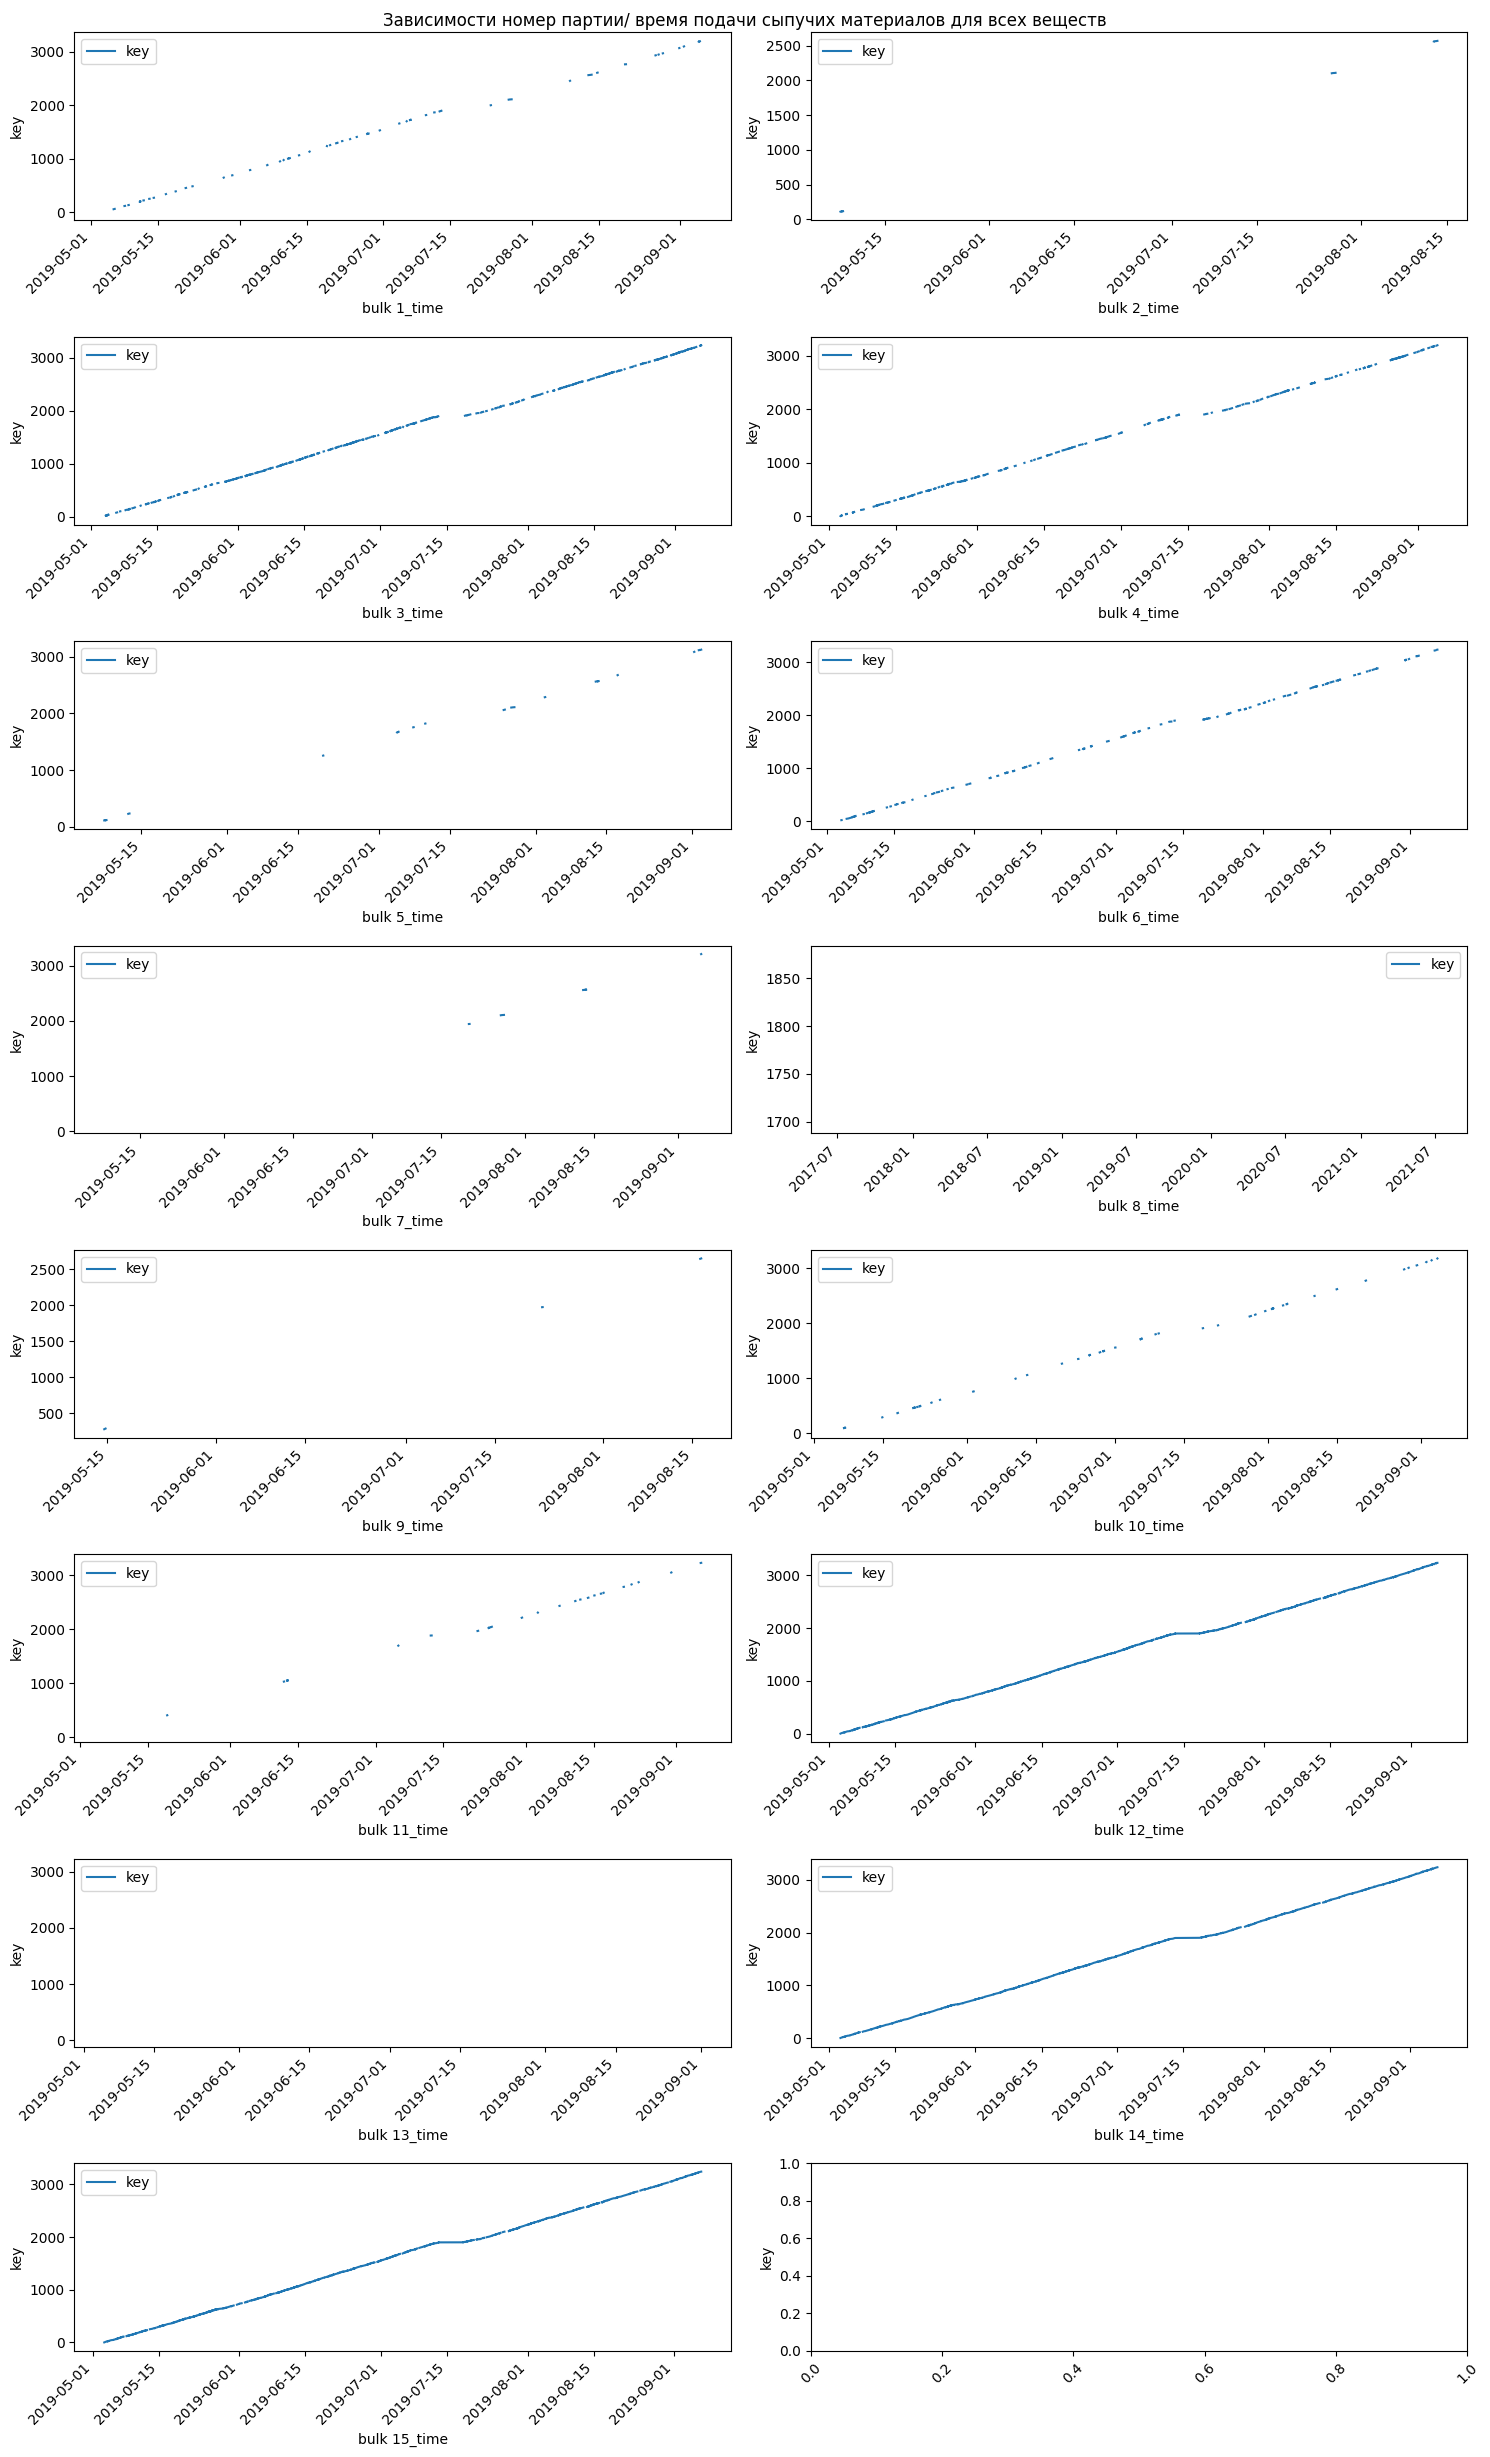

In [50]:
fig, axs = plt.subplots(8, 2,  figsize=(15,25))

data_bulk_time.plot(x = 'bulk 1_time', y ='key', ax = axs[0,0])
data_bulk_time.plot(x = 'bulk 2_time', y ='key', ax = axs[0,1])
data_bulk_time.plot(x = 'bulk 3_time', y ='key', ax = axs[1,0])
data_bulk_time.plot(x = 'bulk 4_time', y ='key', ax = axs[1,1])
data_bulk_time.plot(x = 'bulk 5_time', y ='key', ax = axs[2,0])
data_bulk_time.plot(x = 'bulk 6_time', y ='key', ax = axs[2,1])
data_bulk_time.plot(x = 'bulk 7_time', y ='key', ax = axs[3,0])
data_bulk_time.plot(x = 'bulk 8_time', y ='key', ax = axs[3,1])
data_bulk_time.plot(x = 'bulk 9_time', y ='key', ax = axs[4,0])
data_bulk_time.plot(x = 'bulk 10_time', y ='key', ax = axs[4,1])
data_bulk_time.plot(x = 'bulk 11_time', y ='key', ax = axs[5,0])
data_bulk_time.plot(x = 'bulk 12_time', y ='key', ax = axs[5,1])
data_bulk_time.plot(x = 'bulk 13_time', y ='key', ax = axs[6,0])
data_bulk_time.plot(x = 'bulk 14_time', y ='key', ax = axs[6,1])
data_bulk_time.plot(x = 'bulk 15_time', y ='key', ax = axs[7,0])

for n in range(8):
    for m in range(2):
        axs[n,m].tick_params(axis='x', rotation=45)
        axs[n,m].set_ylabel('key')


axs[0,0].set_title(' ')
plt.suptitle('Зависимости номер партии/ время подачи сыпучих материалов для всех веществ')
plt.tight_layout()
plt.show()

В целом, даты выглядят корректно, кроме bulk 8_time. Видимо, там очень много пропусков.

In [51]:
data_bulk_time['bulk 8_time'].isna().sum()/len(data_bulk_time['bulk 8_time'])

np.float64(0.9996804090763822)

Почти 100% пропусков, поэтому график получился пустой.

Все остальные даты выглядят корректно.

### Данные о продувке сплава газом

Выведем общую информацию о датафрейме.

In [52]:
data_gas.info()
display(f'Дубликатов {data_gas.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


'Дубликатов 0'

В таблице 3239 строк, пропусков и полных дубликатов нет.

Заменим название столбца на латинское и приведем его в нижний регистр.

In [53]:
data_gas=data_gas.rename(columns={'Газ 1':'gas'})

In [54]:
display(data_gas.head())

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Замена произведена корректно.

Объем подаваемого газа принимает числовые значения, можем посторить гистограмму и ящик с усами.

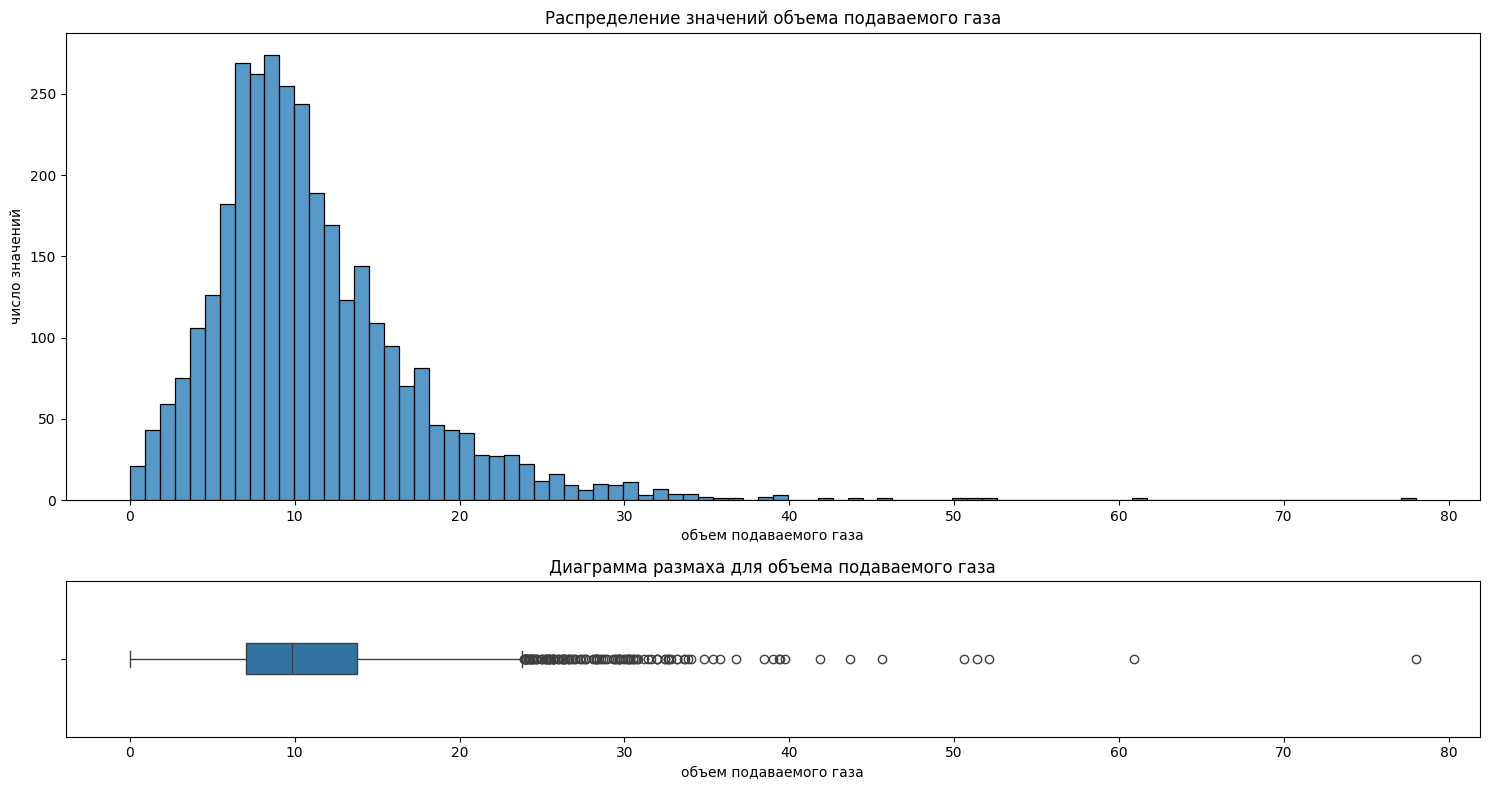

In [55]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

sns.histplot (data = data_gas['gas'], ax=axs[0])

sns.boxplot (data = data_gas['gas'],ax=axs[1], width=0.2, orient='h')

axs[0].set_ylabel('число значений')
axs[0].set_xlabel('объем подаваемого газа')
axs[1].set_xlabel('объем подаваемого газа')

axs[0].set_title('Распределение значений объема подаваемого газа')
axs[1].set_title('Диаграмма размаха для объема подаваемого газа')

plt.tight_layout()
plt.show()

Выведем еще описательные статистики.

In [56]:
display(data_gas['gas'].describe())

,gas
count,3239.000000
mean,11.002062
std,6.220327
min,0.008399
25%,7.043089
50%,9.836267
75%,13.769915
max,77.995040


В целом, распределение объема газа похоже на нормальное, хотя содержит много выбросов.

### Результаты измерения температуры

Общая информация о датафрейме.

In [57]:
data_temp.info()
display(f'Дубликатов {data_temp.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


'Дубликатов 0'

In [58]:
data_temp.isna().sum()

,0
key,0
Время замера,0
Температура,3427


Изменим названия столбцов на 'temp_time' и 'temp'

In [59]:
data_temp=data_temp.rename(columns={'Время замера':'temp_time',
                                    'Температура':'temp'})

Время замера приведем к формату времени.

In [60]:
data_temp['temp_time']=pd.to_datetime(data_temp['temp_time'])

In [61]:
display(data_temp.head())

,key,temp_time,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Проверим временную переменную.

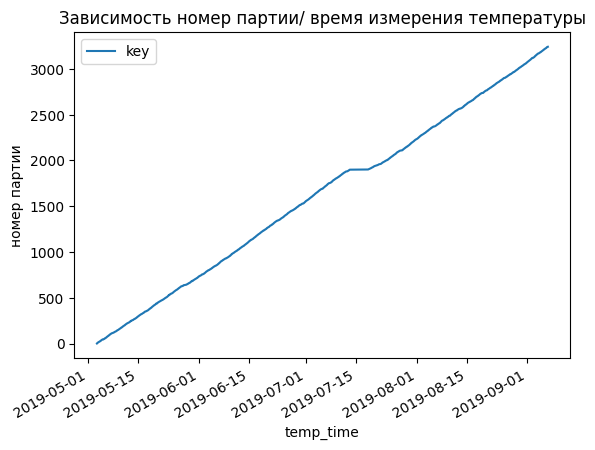

In [62]:
data_temp.plot(x='temp_time',y='key')

plt.title('Зависимость номер партии/ время измерения температуры')
plt.ylabel('номер партии')
plt.show()

Даты выглядят корректно, кроме той недели, когда не происходил нагрев электродами.

Проверим формально, что тогда и не было измерений температуры.

In [63]:
display(data_temp[(data_temp['temp_time']>'2019-07-14') & (data_temp['temp_time']<'2019-07-18')])

,key,temp_time,temp


Действительно, измерения температуры в тот период не проводились.

Исследуем распределение темепературы.

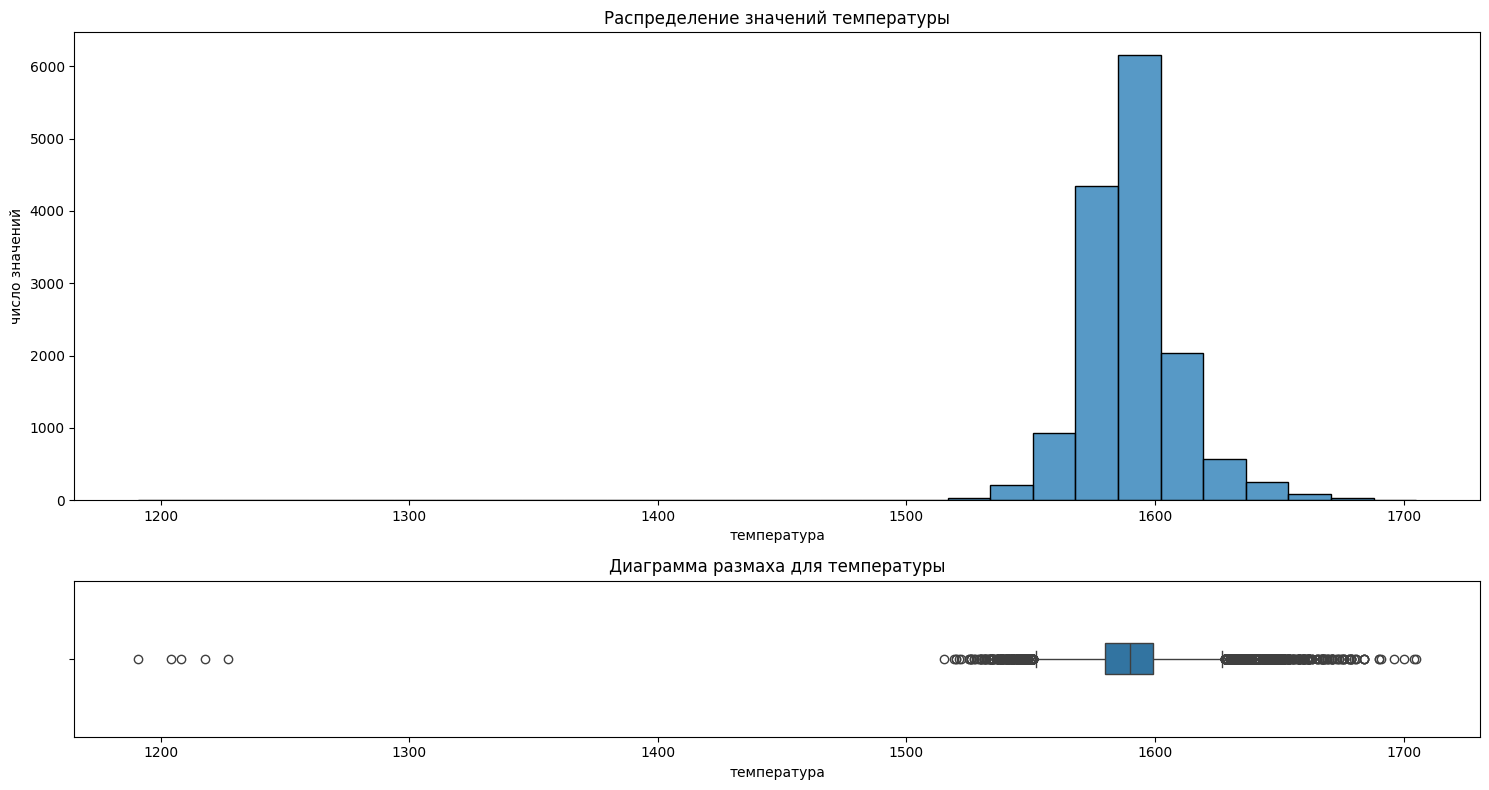

In [64]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

sns.histplot (data = data_temp['temp'], bins = 30,  ax=axs[0])

sns.boxplot(data = data_temp['temp'], ax=axs[1], width=0.2, orient='h')

axs[0].set_ylabel('число значений')
axs[0].set_xlabel('температура')
axs[1].set_xlabel('температура')

axs[0].set_title('Распределение значений температуры')
axs[1].set_title('Диаграмма размаха для температуры')

plt.tight_layout()
plt.show()

Описательные статистики:

In [65]:
display(data_temp['temp'].describe())

,temp
count,14665.000000
mean,1590.722741
std,20.394381
min,1191.000000
25%,1580.000000
50%,1590.000000
75%,1599.000000
max,1705.000000


Значения температуры меньше 1500 градусов - явные аномалии, посмотрим сколько таких значений в датасете.

In [66]:
data_temp[data_temp['temp']<1500].count()

,0
key,5
temp_time,5
temp,5


Всего 5 значений, их можно удалить без потери важной информации.

In [67]:
data_temp=data_temp[data_temp['temp']>1500]

Построим гистограмму распределения температуры и ящик с усами.

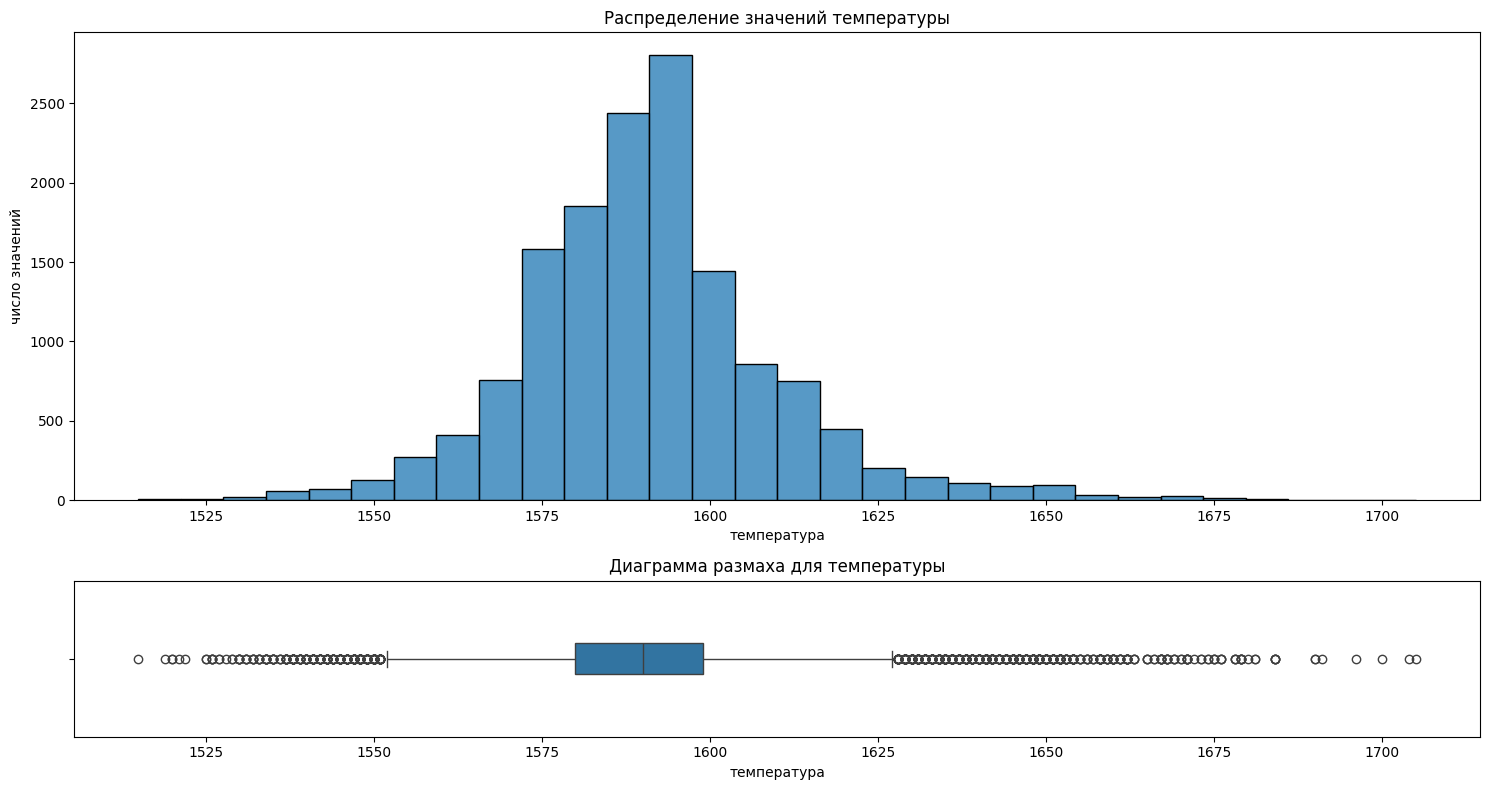

In [68]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

sns.histplot (data = data_temp['temp'], bins = 30, ax=axs[0])

sns.boxplot (data = data_temp['temp'],ax=axs[1], width=0.2, orient='h')

axs[0].set_ylabel('число значений')
axs[0].set_xlabel('температура')
axs[1].set_xlabel('температура')

axs[0].set_title('Распределение значений температуры')
axs[1].set_title('Диаграмма размаха для температуры')

plt.tight_layout()
plt.show()

In [69]:
display(data_temp['temp'].describe())

,temp
count,14660.000000
mean,1590.852729
std,19.143141
min,1515.000000
25%,1580.000000
50%,1590.000000
75%,1599.000000
max,1705.000000


Теперь распределение похоже на нормальное, но оно не симметрично относительно среднего: справа убывает быстрее, чем слева от центра.

Проверим теперь, есть ли ключи с одним замером температуры.

In [70]:
data_tmp = data_temp.groupby('key').count()# число измерений в одной партии
display(data_tmp.head())

,temp_time,temp
key,,
1,6,6
2,5,5
3,6,6
4,5,5
5,5,5


In [71]:
idx = data_tmp.index[data_tmp['temp']==1]#номера ключей с одним замером

In [72]:
print(idx)

Index([ 195,  279, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507,
       ...
       3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241],
      dtype='int64', name='key', length=740)


740 строк с одним замером, их нужно удалить, поскольку они неинформативны для нас.

In [73]:
data_temp=data_temp[~data_temp['key'].isin(idx)]

In [74]:
display(data_temp[data_temp['key']==454])

,key,temp_time,temp
2560,454,2019-05-20 18:21:42,1592.0
2561,454,2019-05-20 18:31:10,1592.0
2562,454,2019-05-20 18:40:46,1594.0
2563,454,2019-05-20 18:49:17,1594.0
2564,454,2019-05-20 18:55:58,1579.0
2565,454,2019-05-20 19:03:19,1591.0


In [75]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13920 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        13920 non-null  int64         
 1   temp_time  13920 non-null  datetime64[ns]
 2   temp       13920 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.0 KB


Проверим еще, есть ли дубли в столбце с временами замера.

In [76]:
data_temp['temp_time'].nunique()

13920

Дублей нет, все значения с временем замера уникальны.

### Данные об объеме проволочных материалов

Общая информация о датафрейме.

In [77]:
data_wire.info()
display(f'Дубликатов {data_arc.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


'Дубликатов 0'

Выведем долю пропусков в каждом столбце.

In [78]:
data_wire.isna().mean()*100

,0
key,0.000000
Wire 1,0.843882
Wire 2,64.978903
Wire 3,97.955209
Wire 4,99.545602
Wire 5,99.967543
Wire 6,97.630639
Wire 7,99.642973
Wire 8,99.383317
Wire 9,99.058747


Из всех столбцов только Wire 1 и Wire 2 имеют меньше 80% пропусков.

Переименуем столбцы для единообразия.

In [79]:
data_wire.columns = [x.lower() for x in data_wire.columns]

In [80]:
display(data_wire.head())

,key,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Заменим пропуски нулями.

In [81]:
for s in data_wire.columns:
    data_wire[s] = data_wire[s].fillna(0)

In [82]:
data_wire.isna().sum()

,0
key,0
wire 1,0
wire 2,0
wire 3,0
wire 4,0
wire 5,0
wire 6,0
wire 7,0
wire 8,0
wire 9,0


Пропусков нет, замена прошла корректно.

Построим гистограммы для всех объемов проволочных материалов.

In [83]:
display(data_wire.head())

,key,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


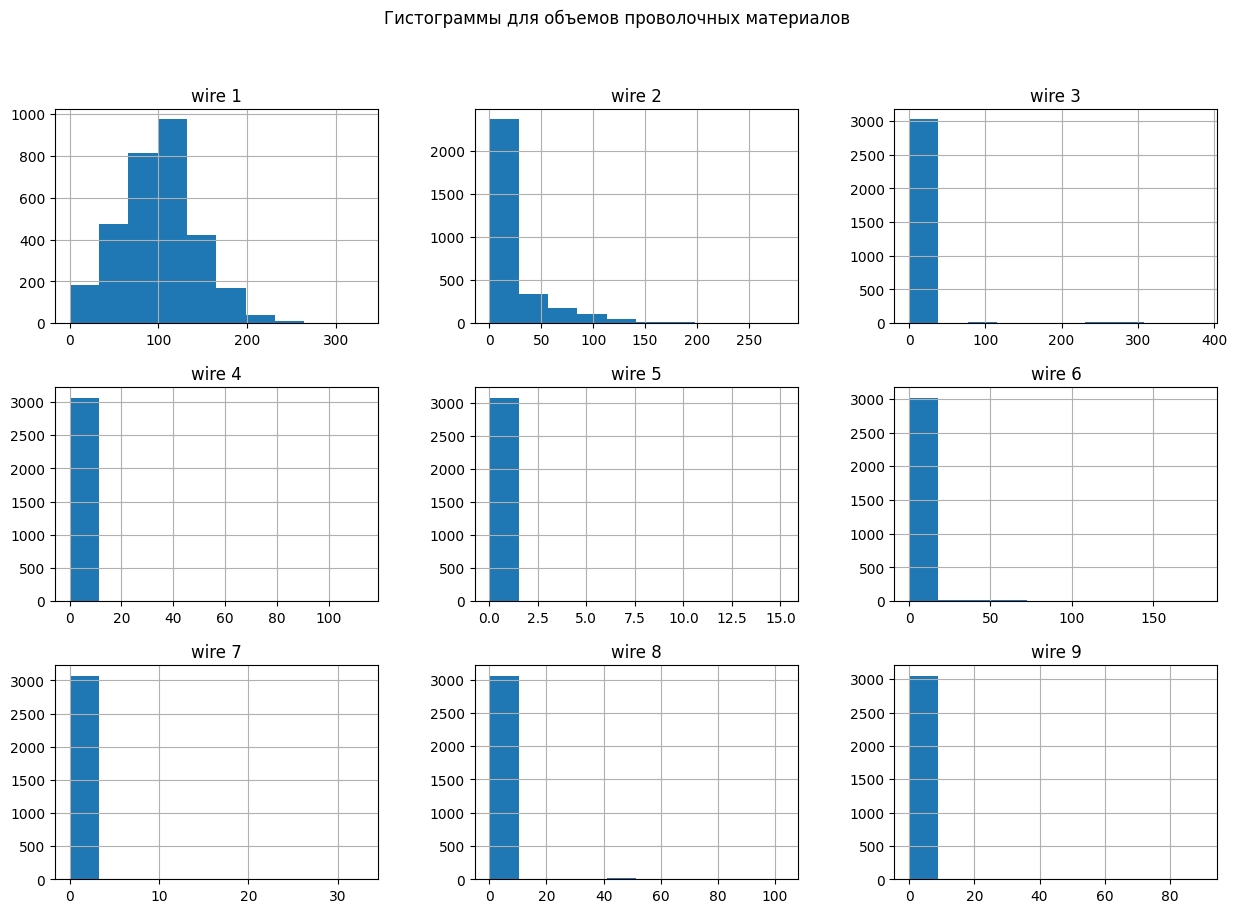

In [84]:
data_wire.drop('key', axis=1).hist(figsize=(15,10))

plt.suptitle('Гистограммы для объемов проволочных материалов')
plt.show()

На гистограммах мы видим в основном наши нули, которыми мы заполнили пропуски.

Только распределение wire 1 похоже на нормальное, все остальные имеют явно вырожденный вид.

### Данные о времени подачи проволочных материалов

Общая информация о датафрейме.

In [85]:
data_wire_time.info()
display(f'Дубликатов {data_arc.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


'Дубликатов 0'

Переименуем столбцы для единообразия.

In [86]:
data_wire_time.columns = [x.lower() for x in data_wire_time.columns]

In [87]:
data_wire_time = data_wire_time.add_suffix('_time')
data_wire_time= data_wire_time.rename(columns={'key_time': 'key'})

Приведем значения времени к формату datetime.

In [88]:
for x in data_wire_time.columns:
    if (x!='key'):
        data_wire_time[x]=pd.to_datetime(data_wire_time[x])

In [89]:
display(data_wire_time.head())

,key,wire 1_time,wire 2_time,wire 3_time,wire 4_time,wire 5_time,wire 6_time,wire 7_time,wire 8_time,wire 9_time
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Пропуски в этом датафрейме заменять не будем, поскольку эти временные переменные мы не будем использовать как признаки.

Проверим только корректность дат.

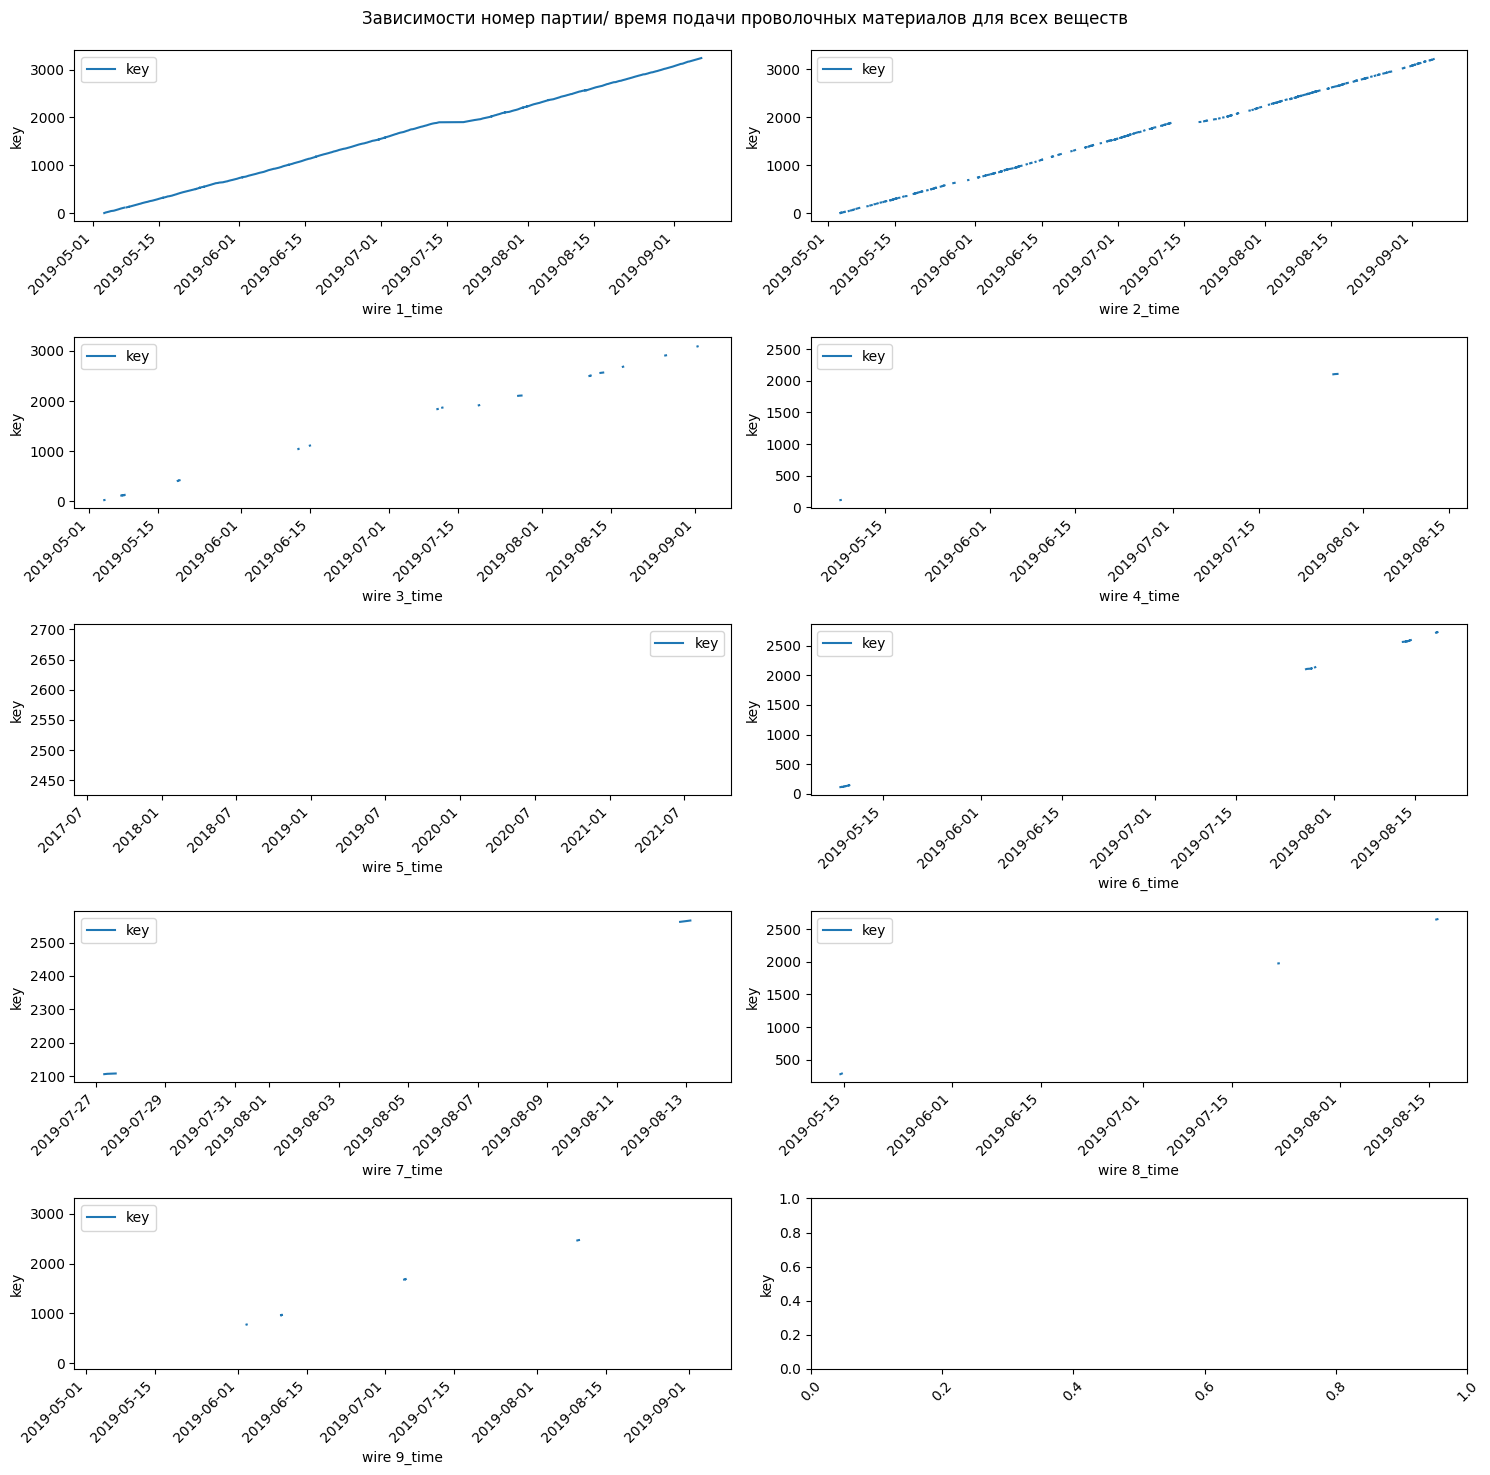

In [90]:
fig, axs = plt.subplots(5, 2,  figsize=(15,15))

data_wire_time.plot(x = 'wire 1_time', y = 'key', ax = axs[0,0])
data_wire_time.plot(x = 'wire 2_time', y = 'key', ax = axs[0,1])
data_wire_time.plot(x = 'wire 3_time', y = 'key', ax = axs[1,0])
data_wire_time.plot(x = 'wire 4_time', y = 'key', ax = axs[1,1])
data_wire_time.plot(x = 'wire 5_time', y = 'key', ax = axs[2,0])
data_wire_time.plot(x = 'wire 6_time', y = 'key', ax = axs[2,1])
data_wire_time.plot(x = 'wire 7_time', y = 'key', ax = axs[3,0])
data_wire_time.plot(x = 'wire 8_time', y = 'key', ax = axs[3,1])
data_wire_time.plot(x = 'wire 9_time', y = 'key', ax = axs[4,0])

for n in range(5):
    for m in range(2):
        axs[n,m].tick_params(axis='x', rotation=45)
        axs[n,m].set_ylabel('key')

axs[0,0].set_title(' ')
plt.suptitle('Зависимости номер партии/ время подачи проволочных материалов для всех веществ')
plt.tight_layout()
plt.show()

<b> Вывод по исследовательскому анализу:</b>

Предобработка и исследовательский анализ проведены для всех 7 датафреймов.

Во всех таблицах столбцы переименованы на латиницу и сделаны строчными для единообразия.
Все временные переменные переведены из строкового в тип datetime, и к их названиям прибавлен суффикс _time,
чтобы разделять их с объемами веществ.

Полных дубликатов нет ни в одной таблице.

Датафреймы с объемами сыпучих и проволочных материалов имеют очень много пропусков:
для сыпучих материалов только 5 столбцов из 15 имеют долю пропусков меньше 80%,
для проволочных - всего 2 из 9.
Пропуски в этих двух датафреймах заменены нулями.
Кроме того, обнаружен период длиною в 5 дней, когда обработка стали не проводилась.

В столбце с реактивной мощностью обнаружено и удалено аномальное отрицательное значение.
Значения температуры меньше 1500 градусов удалены как неправдоподобные.
В таблице с температурой обнаружено 740 ключей только с одним замером, все они удалены как неинформативные для нас.

По распределению из всех переменных только температура, объем газа, bulk 14 из сыпучих и wire 1 из проволочных веществ имеют распределение, похожее на нормальное, хотя практически все эти переменные имеют выбросы.
Мощность (активная и реактивная) скорее распределены по Пуассону.

<a id='section3'></a>
##  Объединение данных

###  Подготовка датафреймов к объединению и создание новых признаков

Выведем еще раз первые строки таблицы с данными об электродах.

In [91]:
data_arc.head()

,key,heat_start,heat_end,power_act,power_react
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Создадим новый признак 'heat_time' - время нагрева - как разницу между окончанием и началом нагрева дугой.

In [92]:
data_arc['heat_time']=data_arc['heat_end']-data_arc['heat_start']

In [93]:
data_arc.head()

,key,heat_start,heat_end,power_act,power_react,heat_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0 days 00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:02:28


Теперь создадим сводную таблицу по ключу, для столбцов мощности выведем среднее по партии, для нового признака времени нагрева выведем сумму по партии, для начала нагрева выведем минимальное значение, для окончания нагрева выведем максимальное значение.

In [94]:
data_arc_pivot = data_arc.pivot_table(
                     index=['key'],
                     values=['heat_start',
                             'heat_end',
                             'power_act',
                             'power_react',
                             'heat_time'],
                     aggfunc={'heat_start':'min',
                              'heat_end':'max',
                              'power_act':'mean',
                              'power_react':'mean',
                              'heat_time':'sum'}).reset_index()

display(data_arc_pivot)

,key,heat_end,heat_start,heat_time,power_act,power_react
0,1,2019-05-03 11:28:37,2019-05-03 11:02:14,0 days 00:18:18,0.607346,0.428564
1,2,2019-05-03 11:53:18,2019-05-03 11:34:14,0 days 00:13:31,0.534852,0.363339
2,3,2019-05-03 12:32:19,2019-05-03 12:06:54,0 days 00:10:55,0.812728,0.587491
3,4,2019-05-03 12:57:50,2019-05-03 12:39:37,0 days 00:12:21,0.676622,0.514248
4,5,2019-05-03 13:33:55,2019-05-03 13:11:13,0 days 00:14:29,0.563238,0.421998
...,...,...,...,...,...,...
3209,3237,2019-09-06 11:53:55,2019-09-06 11:31:25,0 days 00:15:09,0.508374,0.405083
3210,3238,2019-09-06 12:31:35,2019-09-06 12:16:25,0 days 00:09:06,0.458274,0.346034
3211,3239,2019-09-06 15:05:50,2019-09-06 14:17:00,0 days 00:20:16,0.606001,0.442693
3212,3240,2019-09-06 16:24:15,2019-09-06 15:25:31,0 days 00:13:59,0.663536,0.474710


Создадим еще признак 'power' - общая мощность, который равен квадратному корню из суммы квадратов активной и реактивной мощности.

In [95]:
data_arc_pivot['power']=np.sqrt(data_arc_pivot['power_act'].pow(2) + data_arc_pivot['power_react'].pow(2))

In [96]:
display(data_arc_pivot.head())

,key,heat_end,heat_start,heat_time,power_act,power_react,power
0,1,2019-05-03 11:28:37,2019-05-03 11:02:14,0 days 00:18:18,0.607346,0.428564,0.743328
1,2,2019-05-03 11:53:18,2019-05-03 11:34:14,0 days 00:13:31,0.534852,0.363339,0.646593
2,3,2019-05-03 12:32:19,2019-05-03 12:06:54,0 days 00:10:55,0.812728,0.587491,1.002833
3,4,2019-05-03 12:57:50,2019-05-03 12:39:37,0 days 00:12:21,0.676622,0.514248,0.849864
4,5,2019-05-03 13:33:55,2019-05-03 13:11:13,0 days 00:14:29,0.563238,0.421998,0.703789


В итоговой таблице времена начала и окончания нагрева дугой нам не понадобятся,  из них мы получили общее время нагревания как признак, поэтому эти столбцы удаляем.

In [97]:
data_arc_pivot = data_arc_pivot.drop(['heat_start','heat_end'],axis=1)
display(data_arc_pivot.head())

,key,heat_time,power_act,power_react,power
0,1,0 days 00:18:18,0.607346,0.428564,0.743328
1,2,0 days 00:13:31,0.534852,0.363339,0.646593
2,3,0 days 00:10:55,0.812728,0.587491,1.002833
3,4,0 days 00:12:21,0.676622,0.514248,0.849864
4,5,0 days 00:14:29,0.563238,0.421998,0.703789


Последнее, что сделаем - переведем столбец 'heat_time' в секунды, чтобы он стал численным признаком.

In [98]:
data_arc_pivot['heat_time']=data_arc_pivot['heat_time'].dt.total_seconds()

In [99]:
data_arc_pivot.head()

,key,heat_time,power_act,power_react,power
0,1,1098.0,0.607346,0.428564,0.743328
1,2,811.0,0.534852,0.363339,0.646593
2,3,655.0,0.812728,0.587491,1.002833
3,4,741.0,0.676622,0.514248,0.849864
4,5,869.0,0.563238,0.421998,0.703789


In [100]:
data_arc_pivot.shape[0]

3214

Эта таблица готова к объединению.

Из таблицы об объеме сыпучих материалов мы возьмем только те столбцы, где пропусков было меньше 80% (п.2.2)

In [101]:
data_bulk = data_bulk.loc[:, ['key', 'bulk 3', 'bulk 4', 'bulk 12', 'bulk 14', 'bulk 15']]

In [102]:
data_bulk.head()

,key,bulk 3,bulk 4,bulk 12,bulk 14,bulk 15
0,1,0.0,43.0,206.0,150.0,154.0
1,2,0.0,73.0,206.0,149.0,154.0
2,3,0.0,34.0,205.0,152.0,153.0
3,4,0.0,81.0,207.0,153.0,154.0
4,5,0.0,78.0,203.0,151.0,152.0


In [103]:
data_bulk.shape[0]

3129

Эта таблица также готова к объединению.

Из таблицы с объемами проволочных материалов мы также оставим только те столбцы, где пропусков было меньше 80% (п. 2.6)

In [104]:
data_wire = data_wire.loc[:, ['key','wire 1', 'wire 2']]

In [105]:
data_wire.head()

,key,wire 1,wire 2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


In [106]:
data_wire.shape[0]

3081

Эта таблица готова к объединению.

Таблица с объемами газа не требует подготовки.

Теперь займемся датафреймом со значениями измеренной температуры. Выведем еще раз эту таблицу.

In [107]:
data_temp.head(10)

,key,temp_time,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


Нам нужно выделить значения температуры в начале и в конце обработки каждой партии.

Составим сводную таблицу по номеру ключа, для каждого ключа (то есть партии)  выведем минимальное и максимальное время замера температуры.

Вспомним, что все значения времени измерения температуры уникальны, поэтому в полученных столбцах повторений также не будет.

In [108]:
data_temp_pivot = data_temp.pivot_table(
                     index='key',
                     values='temp_time',
                     aggfunc={'min', 'max'}).reset_index()

display(data_temp_pivot)

,key,max,min
0,1,2019-05-03 11:30:38,2019-05-03 11:02:04
1,2,2019-05-03 11:55:09,2019-05-03 11:34:04
2,3,2019-05-03 12:35:57,2019-05-03 12:06:44
3,4,2019-05-03 12:59:47,2019-05-03 12:39:27
4,5,2019-05-03 13:36:39,2019-05-03 13:11:03
...,...,...,...
2470,2495,2019-08-10 11:50:47,2019-08-10 11:27:47
2471,2496,2019-08-10 12:25:13,2019-08-10 11:56:48
2472,2497,2019-08-10 12:53:28,2019-08-10 12:37:26
2473,2498,2019-08-10 13:23:31,2019-08-10 12:58:11


In [109]:
display(data_temp_pivot[data_temp_pivot['key']==49])

,key,max,min
46,49,2019-05-05 10:50:46,2019-05-05 09:51:12


In [110]:
display(data_temp[data_temp['key']==49])

,key,temp_time,temp
279,49,2019-05-05 09:51:12,1626.0
280,49,2019-05-05 10:50:46,1588.0


Теперь нам нужно еще включить в таблицу значения измеренной температуры в эти времена max и min.

Для этого мы объединим сводную таблицу с исходной data_temp по времени измерения: сначала по первому измерению, потом по последнему.

Объединение будем производить способом 'inner', чтобы в таблицу вошли только измерения в нужные нам моменты max и min.

Для объединения нужно, чтобы названия столбцов, по которым будем объединять, совпадали.

Переименуем в сводной таблице 'min' на 'temp_time'.

In [111]:
data_temp_pivot=data_temp_pivot.rename(columns={'min': 'temp_time' } )
display(data_temp_pivot.head())

,key,max,temp_time
0,1,2019-05-03 11:30:38,2019-05-03 11:02:04
1,2,2019-05-03 11:55:09,2019-05-03 11:34:04
2,3,2019-05-03 12:35:57,2019-05-03 12:06:44
3,4,2019-05-03 12:59:47,2019-05-03 12:39:27
4,5,2019-05-03 13:36:39,2019-05-03 13:11:03


Теперь объединяем таблицы по времени первого измерения.

In [112]:
data_1 = data_temp_pivot.merge(data_temp, on='temp_time', how='inner')
display(data_1.head())

,key_x,max,temp_time,key_y,temp
0,1,2019-05-03 11:30:38,2019-05-03 11:02:04,1,1571.0
1,2,2019-05-03 11:55:09,2019-05-03 11:34:04,2,1581.0
2,3,2019-05-03 12:35:57,2019-05-03 12:06:44,3,1596.0
3,4,2019-05-03 12:59:47,2019-05-03 12:39:27,4,1601.0
4,5,2019-05-03 13:36:39,2019-05-03 13:11:03,5,1576.0


In [113]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key_x      2475 non-null   int64         
 1   max        2475 non-null   datetime64[ns]
 2   temp_time  2475 non-null   datetime64[ns]
 3   key_y      2475 non-null   int64         
 4   temp       2475 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 96.8 KB


В новой таблице 3085 строк, так же как и в сводной.

Теперь в этой таблице время, по которому шло объединение, назовем стартовым 'temp_time_start', температуру 'temp_start', а время последнего измерения 'max' переименуем в 'temp_time', чтобы объединить ее с исходной data_temp по времени последнего измерения.

In [114]:
data_1=data_1.rename(columns={'max': 'temp_time', 'temp_time' : 'temp_time_start', 'temp':'temp_start'} )
display(data_1.head())

,key_x,temp_time,temp_time_start,key_y,temp_start
0,1,2019-05-03 11:30:38,2019-05-03 11:02:04,1,1571.0
1,2,2019-05-03 11:55:09,2019-05-03 11:34:04,2,1581.0
2,3,2019-05-03 12:35:57,2019-05-03 12:06:44,3,1596.0
3,4,2019-05-03 12:59:47,2019-05-03 12:39:27,4,1601.0
4,5,2019-05-03 13:36:39,2019-05-03 13:11:03,5,1576.0


In [115]:
data_2 = data_temp.merge(data_1, on='temp_time', how='inner')
display(data_2.head())

,key,temp_time,temp,key_x,temp_time_start,key_y,temp_start
0,1,2019-05-03 11:30:38,1613.0,1,2019-05-03 11:02:04,1,1571.0
1,2,2019-05-03 11:55:09,1602.0,2,2019-05-03 11:34:04,2,1581.0
2,3,2019-05-03 12:35:57,1599.0,3,2019-05-03 12:06:44,3,1596.0
3,4,2019-05-03 12:59:47,1625.0,4,2019-05-03 12:39:27,4,1601.0
4,5,2019-05-03 13:36:39,1602.0,5,2019-05-03 13:11:03,5,1576.0


Объединили таблицы по времени последнего измерения, теперь переименовываем столбцы в 'temp_time_end' и 'temp_end' и удаляем ненужные уже столбцы с ключами 'key_x','key_y'.

In [116]:
data_2=data_2.rename(columns={'temp_time' : 'temp_time_end', 'temp':'temp_end'} )
display(data_2.head())

,key,temp_time_end,temp_end,key_x,temp_time_start,key_y,temp_start
0,1,2019-05-03 11:30:38,1613.0,1,2019-05-03 11:02:04,1,1571.0
1,2,2019-05-03 11:55:09,1602.0,2,2019-05-03 11:34:04,2,1581.0
2,3,2019-05-03 12:35:57,1599.0,3,2019-05-03 12:06:44,3,1596.0
3,4,2019-05-03 12:59:47,1625.0,4,2019-05-03 12:39:27,4,1601.0
4,5,2019-05-03 13:36:39,1602.0,5,2019-05-03 13:11:03,5,1576.0


In [117]:
data_2=data_2.drop(['key_x','key_y'],axis=1)
display(data_2.head())

,key,temp_time_end,temp_end,temp_time_start,temp_start
0,1,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:04,1571.0
1,2,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:04,1581.0
2,3,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:44,1596.0
3,4,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,1601.0
4,5,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,1576.0


Создадим новый признак 'time_between' - время между первым и последним измерениями температуры в партии.

In [118]:
data_2['time_between']=data_2['temp_time_end']-data_2['temp_time_start']
display(data_2.head())
data_2.info()

,key,temp_time_end,temp_end,temp_time_start,temp_start,time_between
0,1,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:04,1571.0,0 days 00:28:34
1,2,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:04,1581.0,0 days 00:21:05
2,3,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:44,1596.0,0 days 00:29:13
3,4,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,1601.0,0 days 00:20:20
4,5,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,1576.0,0 days 00:25:36


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   key              2475 non-null   int64          
 1   temp_time_end    2475 non-null   datetime64[ns] 
 2   temp_end         2475 non-null   float64        
 3   temp_time_start  2475 non-null   datetime64[ns] 
 4   temp_start       2475 non-null   float64        
 5   time_between     2475 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), timedelta64[ns](1)
memory usage: 116.1 KB


Переведем значение этой переменной в секунды, чтобы использовать его как числовой признак.

In [119]:
data_2['time_between']=data_2['time_between'].dt.total_seconds()

Последняя проверка на наличие одного измерения температуры в партии.

Проверим, есть ли совпадения в столбцах 'temp_time_end' и 'temp_time_start'.

In [120]:
data_2[data_2['temp_time_end']==data_2['temp_time_start']].count()

,0
key,0
temp_time_end,0
temp_end,0
temp_time_start,0
temp_start,0
time_between,0


Временные переменные нам больше не понадобятся, мы можем их удалить.

In [121]:
data_2 = data_2.drop(['temp_time_start','temp_time_end'], axis=1)
display(data_2.head())

,key,temp_end,temp_start,time_between
0,1,1613.0,1571.0,1714.0
1,2,1602.0,1581.0,1265.0
2,3,1599.0,1596.0,1753.0
3,4,1625.0,1601.0,1220.0
4,5,1602.0,1576.0,1536.0


Теперь таблица с температурой готова к объединению.

###  Объединение датафреймов

Теперь объединим все подготовленные датафреймы в один методом merge по столбцу 'key'.

В общую таблицу попадут только строки с номерами партий, которые встречаются во всех таблицах.

In [122]:
data_all = pd.merge (pd.merge (pd.merge (pd.merge
           (data_bulk, data_wire, on = 'key', how ='inner'),
            data_gas,  on = 'key', how ='inner'),
            data_arc_pivot, on = 'key', how ='inner'),
            data_2, on = 'key', how ='inner')

display(data_all.tail())#выводим последние строки

,key,bulk 3,bulk 4,bulk 12,bulk 14,bulk 15,wire 1,wire 2,gas,heat_time,power_act,power_react,power,temp_end,temp_start,time_between
2324,2495,21.0,0.0,256.0,129.0,223.0,89.150879,0.00000,7.125735,723.0,0.792033,0.552734,0.965832,1591.0,1570.0,1380.0
2325,2496,0.0,63.0,256.0,129.0,226.0,114.179527,0.00000,9.412616,940.0,0.695820,0.478672,0.844566,1591.0,1554.0,1705.0
2326,2497,0.0,85.0,230.0,124.0,226.0,94.086723,9.04800,6.271699,569.0,1.201746,0.817364,1.453368,1589.0,1571.0,962.0
2327,2498,90.0,0.0,206.0,129.0,207.0,118.110717,0.00000,14.953657,750.0,0.640462,0.447964,0.781577,1594.0,1591.0,1520.0
2328,2499,47.0,0.0,233.0,126.0,227.0,110.160958,50.00528,11.336151,883.0,0.434271,0.324209,0.541944,1603.0,1569.0,1537.0


Число строк в таблице 2329, номера ключей не превосходят 2500.

Номер патрии нам больше не понадобится, его можно удалить.

In [123]:
data_all = data_all.drop('key',axis=1)
display(data_all.head())

,bulk 3,bulk 4,bulk 12,bulk 14,bulk 15,wire 1,wire 2,gas,heat_time,power_act,power_react,power,temp_end,temp_start,time_between
0,0.0,43.0,206.0,150.0,154.0,60.059998,0.00000,29.749986,1098.0,0.607346,0.428564,0.743328,1613.0,1571.0,1714.0
1,0.0,73.0,206.0,149.0,154.0,96.052315,0.00000,12.555561,811.0,0.534852,0.363339,0.646593,1602.0,1581.0,1265.0
2,0.0,34.0,205.0,152.0,153.0,91.160157,0.00000,28.554793,655.0,0.812728,0.587491,1.002833,1599.0,1596.0,1753.0
3,0.0,81.0,207.0,153.0,154.0,89.063515,0.00000,18.841219,741.0,0.676622,0.514248,0.849864,1625.0,1601.0,1220.0
4,0.0,78.0,203.0,151.0,152.0,89.238236,9.11456,5.413692,869.0,0.563238,0.421998,0.703789,1602.0,1576.0,1536.0


<b>Вывод по подготовке данных к объединению</b>

В таблице с данными об электродах созданы новые признаки:  время нагрева (разница между окончанием и началом нагрева дугой в секундах) и общая мощность.

С помощью сводной таблицы для каждой партии выведены средние мощности (активная, реактивная и общая) и суммы времени нагрева дугой.

В таблицах с сыпучими и проволочными материалами оставлены только столбцы, в которых было меньше 80% пропусков.

Таблица с объемами газа не изменялась.

В таблице со значениями температуры с помощью сводной таблицы и объединения по методу merge получены начальные и конечные значения температуры для каждой партии.

Создан новый признак - время между первым и последним измерениями температуры в партии в секундах.

Обнаружено 745 единичных измерений в партии, у которых времена первого и последнего измерения совпадают, все они удалены.

Во всех таблицах удалены переменные с форматом даты, поскольку они преобразованы в численные признаки.

Подготовленные датафреймы объединены в один методом merge по столбцу 'key' (метод объединения inner, что означает, что в общую таблицу попадают только строки с номерами партий, которые встречаются во всех таблицах).


<a id='section4'></a>
##  Исследовательский анализ и предобработка данных объединенного датафрейма

### Исследовательский анализ объединенного датафрейма

Выведем общую информацию об объединенном датафрейме.

In [124]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bulk 3        2329 non-null   float64
 1   bulk 4        2329 non-null   float64
 2   bulk 12       2329 non-null   float64
 3   bulk 14       2329 non-null   float64
 4   bulk 15       2329 non-null   float64
 5   wire 1        2329 non-null   float64
 6   wire 2        2329 non-null   float64
 7   gas           2329 non-null   float64
 8   heat_time     2329 non-null   float64
 9   power_act     2329 non-null   float64
 10  power_react   2329 non-null   float64
 11  power         2329 non-null   float64
 12  temp_end      2329 non-null   float64
 13  temp_start    2329 non-null   float64
 14  time_between  2329 non-null   float64
dtypes: float64(15)
memory usage: 273.1 KB


Таблица содержит 2194 строки, все переменные имеют правильный тип.

Построим гистограммы для всех переменных в общем датафрейме.

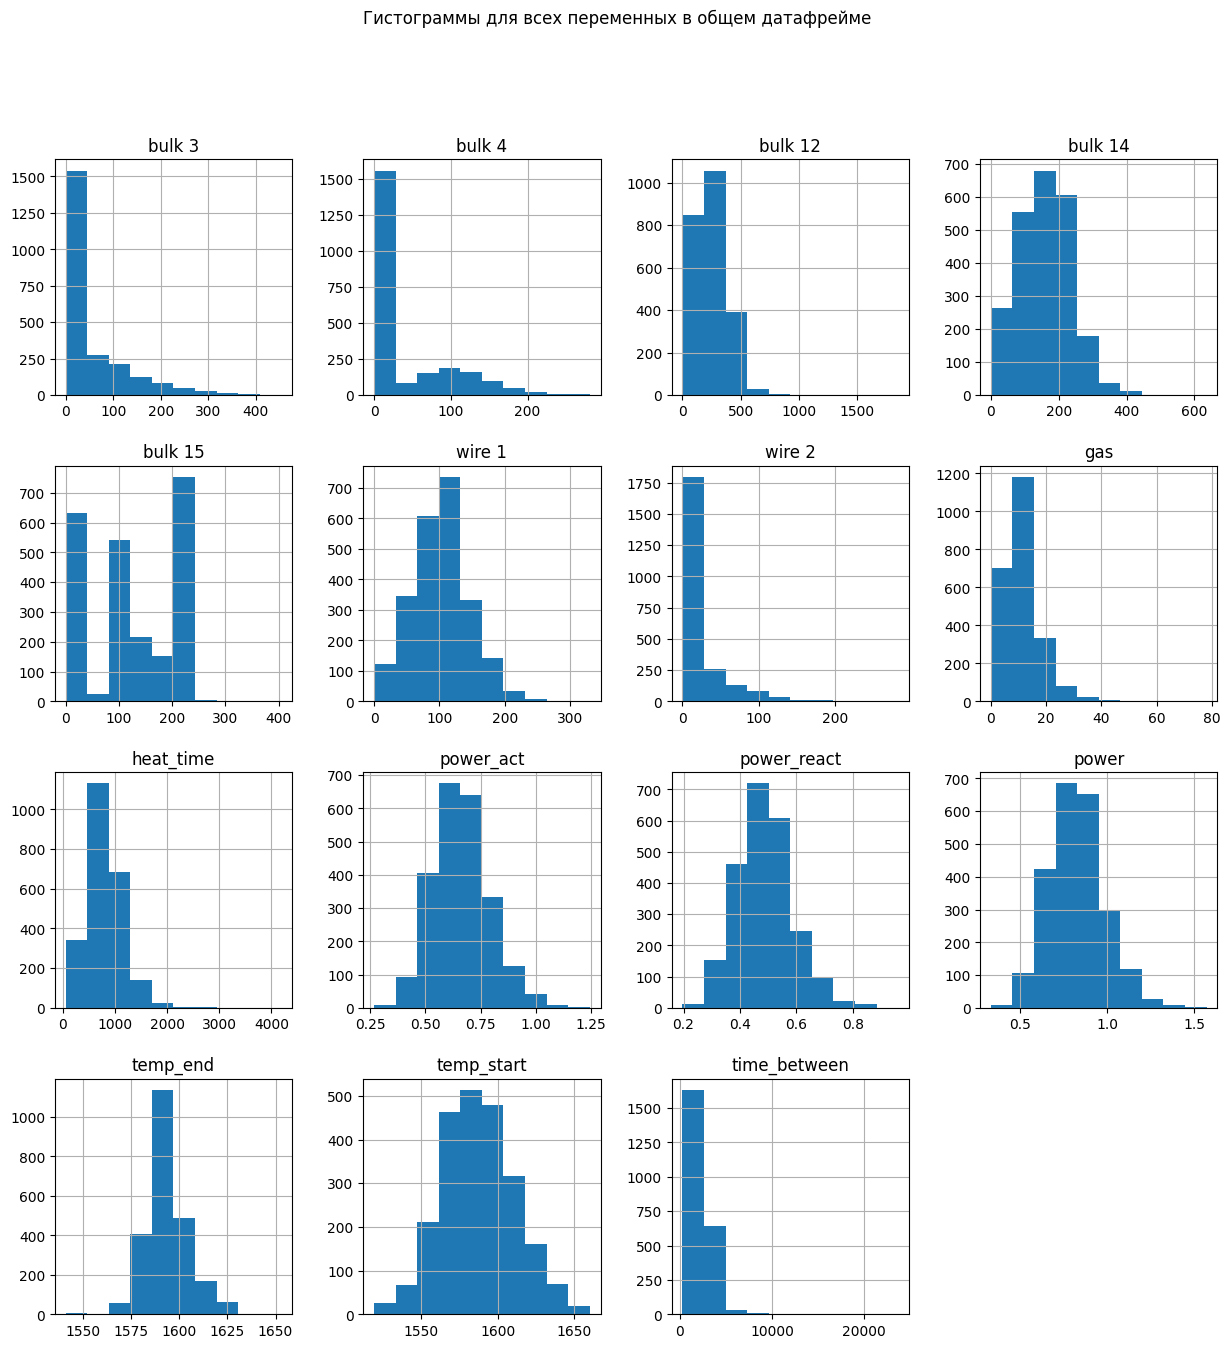

In [125]:
data_all.hist(figsize=(15,15))

plt.suptitle('Гистограммы для всех переменных в общем датафрейме')
plt.show()

Сначала рассмотрим сыпучие вещества.

В гистограммах мы видим очень много нулей, которые мы сами добавили.

Кроме того, для каждого вещества распределение выглядит по разному.

Построим диаграммы размаха для всех веществ на одном графике для экономии места и более наглядного представления.

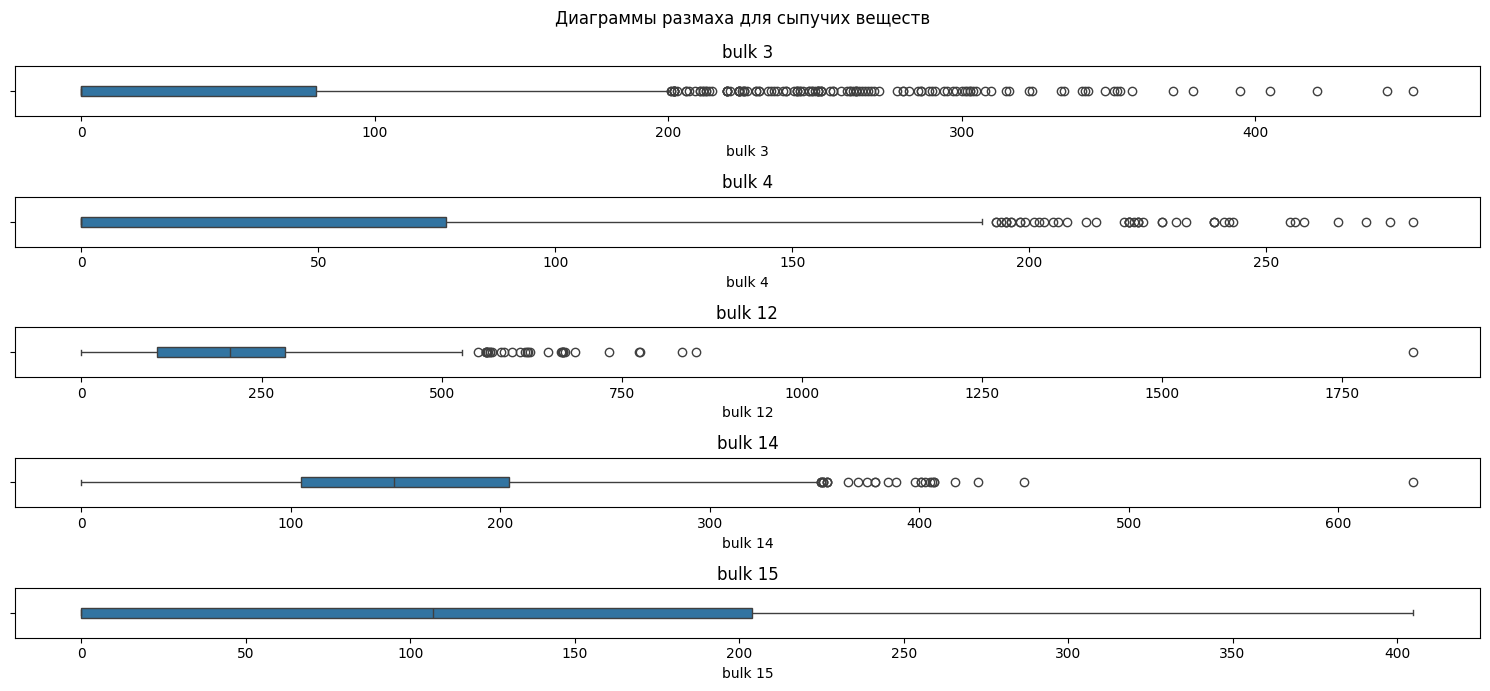

In [126]:
fig, axs = plt.subplots(5, 1, figsize=(15, 7))
fig.suptitle('Диаграммы размаха для сыпучих веществ ')

sns.boxplot (data = data_all['bulk 3'], ax = axs[0], width = 0.2, orient ='h')
sns.boxplot (data = data_all['bulk 4'], ax = axs[1], width = 0.2, orient ='h')
sns.boxplot (data = data_all['bulk 12'], ax = axs[2], width = 0.2, orient ='h')
sns.boxplot (data = data_all['bulk 14'], ax = axs[3], width = 0.2, orient ='h')
sns.boxplot (data = data_all['bulk 15'], ax = axs[4], width = 0.2, orient ='h')


axs[0].set_title('bulk 3')
axs[1].set_title('bulk 4')
axs[2].set_title('bulk 12')
axs[3].set_title('bulk 14')
axs[4].set_title('bulk 15')


plt.tight_layout()
plt.show()

Выведем еще описательные статистики для всех веществ.

In [127]:
s = ['bulk 3','bulk 4','bulk 12','bulk 14','bulk 15']
data_all[s].describe()

,bulk 3,bulk 4,bulk 12,bulk 14,bulk 15
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,47.348218,37.303564,208.415629,153.853585,119.952769
std,75.310430,58.643238,157.062272,81.404354,84.640443
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,105.000000,105.000000,0.000000
50%,0.000000,0.000000,206.000000,149.000000,107.000000
75%,80.000000,77.000000,282.000000,204.000000,204.000000
max,454.000000,281.000000,1849.000000,636.000000,405.000000


Теперь рассмотрим проволочные материалы, из них мы взяли всего 2 в итоговую таблицу.

Построим диаграммы размаха и выведем описательные статистики.

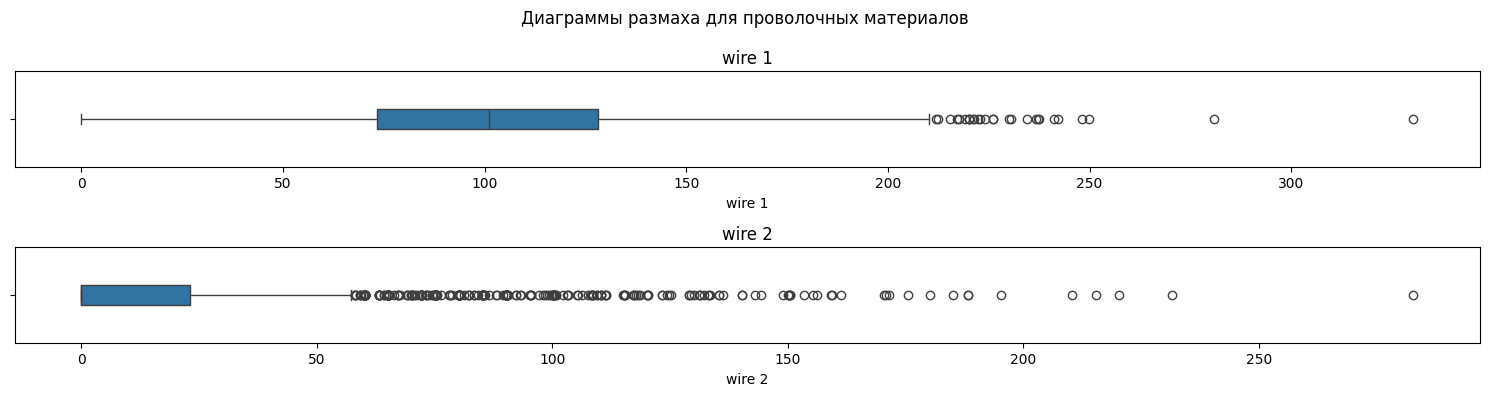

In [128]:
fig, axs = plt.subplots(2, 1, figsize=(15,4))
fig.suptitle('Диаграммы размаха для проволочных материалов')

sns.boxplot (data = data_all['wire 1'], ax=axs[0], width=0.2, orient='h')
sns.boxplot (data = data_all['wire 2'], ax=axs[1], width=0.2, orient='h')

axs[0].set_title('wire 1')
axs[1].set_title('wire 2')

plt.tight_layout()
plt.show()

In [129]:
s = ['wire 1','wire 2']
data_all[s].describe()

,wire 1,wire 2
count,2329.000000,2329.000000
mean,102.443601,17.609859
std,43.539993,33.624771
min,0.000000,0.000000
25%,73.207679,0.000000
50%,101.119201,0.000000
75%,128.091599,23.102560
max,330.314424,282.780152


Рассмотрим объем подаваемого газа.

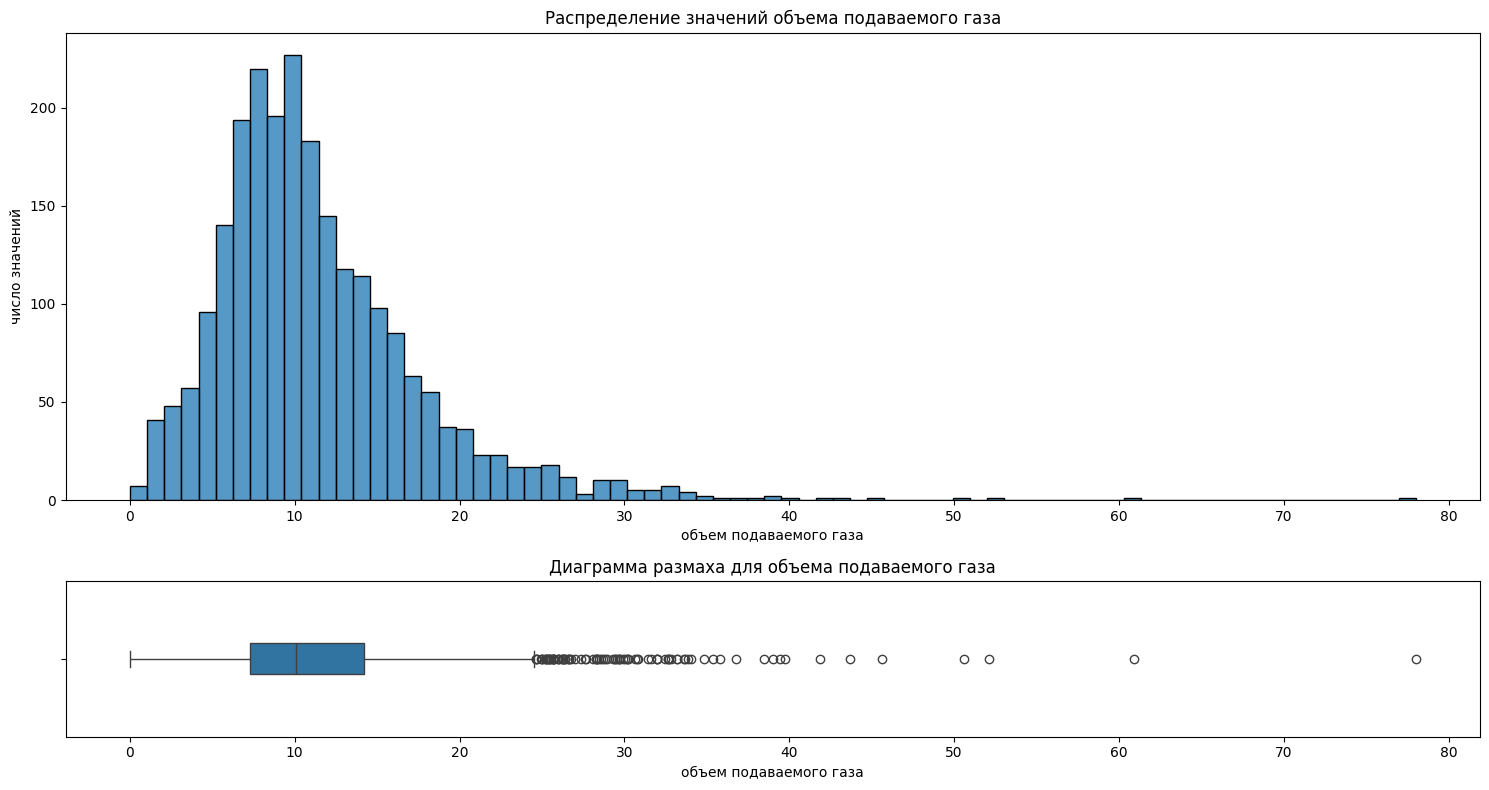

In [130]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

sns.histplot (data = data_all['gas'], ax=axs[0])

sns.boxplot (data = data_all['gas'], ax=axs[1], width=0.2, orient='h')

axs[0].set_ylabel('число значений')
axs[0].set_xlabel('объем подаваемого газа')
axs[1].set_xlabel('объем подаваемого газа')

axs[0].set_title('Распределение значений объема подаваемого газа')
axs[1].set_title('Диаграмма размаха для объема подаваемого газа')

plt.tight_layout()
plt.show()

In [131]:
data_all['gas'].describe()

,gas
count,2329.000000
mean,11.375600
std,6.392041
min,0.008399
25%,7.282948
50%,10.100950
75%,14.216688
max,77.995040


Теперь исследуем новый признак -  время нагрева электродами.

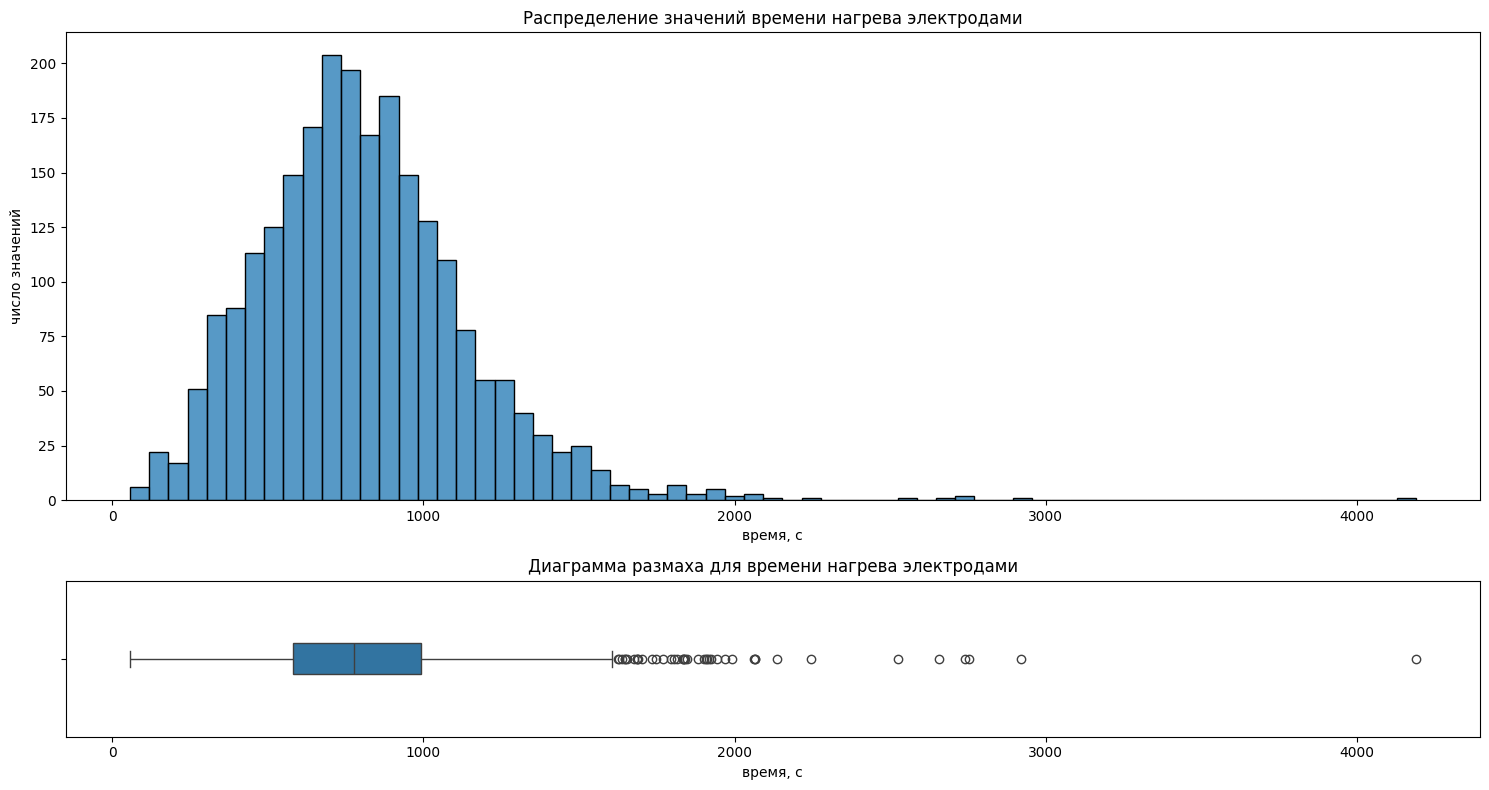

In [132]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

sns.histplot (data = data_all['heat_time'], ax=axs[0])

sns.boxplot (data = data_all['heat_time'], ax=axs[1], width=0.2, orient='h')

axs[0].set_ylabel('число значений')
axs[0].set_xlabel('время, с')
axs[1].set_xlabel('время, с')

axs[0].set_title('Распределение значений времени нагрева электродами')
axs[1].set_title('Диаграмма размаха для времени нагрева электродами')

plt.tight_layout()
plt.show()

In [133]:
data_all['heat_time'].describe()

,heat_time
count,2329.000000
mean,807.600687
std,340.897332
min,57.000000
25%,581.000000
50%,778.000000
75%,993.000000
max,4189.000000


Распределения активной, реактивной и полной мощности очень похожи, построим три гистограммы на одном графике.

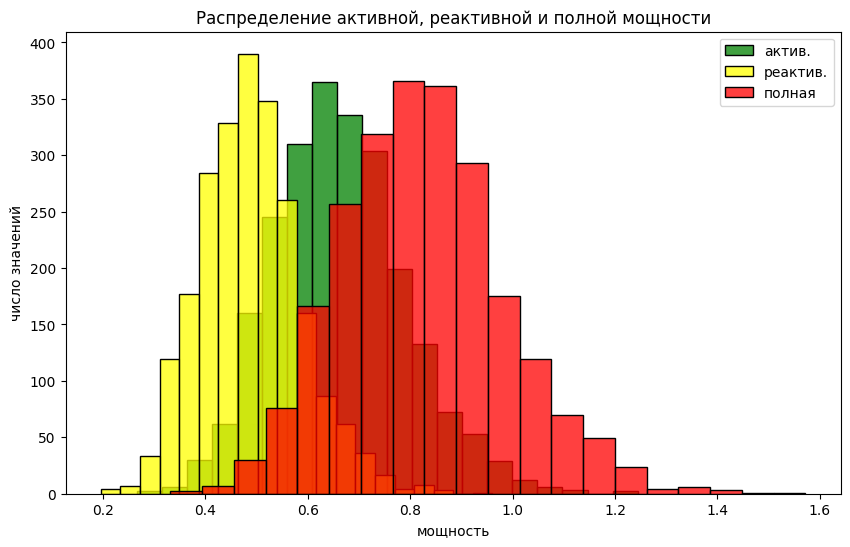

In [134]:
fig = plt.subplots(figsize=(10,6))

sns.histplot(data_all['power_act'], color = 'green', label = 'актив.', bins = 20)
sns.histplot(data_all['power_react'], color = 'yellow',label = 'реактив.',bins = 20)
sns.histplot(data_all['power'], color = 'red', label = 'полная', bins=20)

plt.title('Распределение активной, реактивной и полной мощности')
plt.xlabel('мощность')
plt.ylabel('число значений')

plt.legend()
plt.show()

Построим еще диаграммы размаха для всех трех переменных на одном графике.

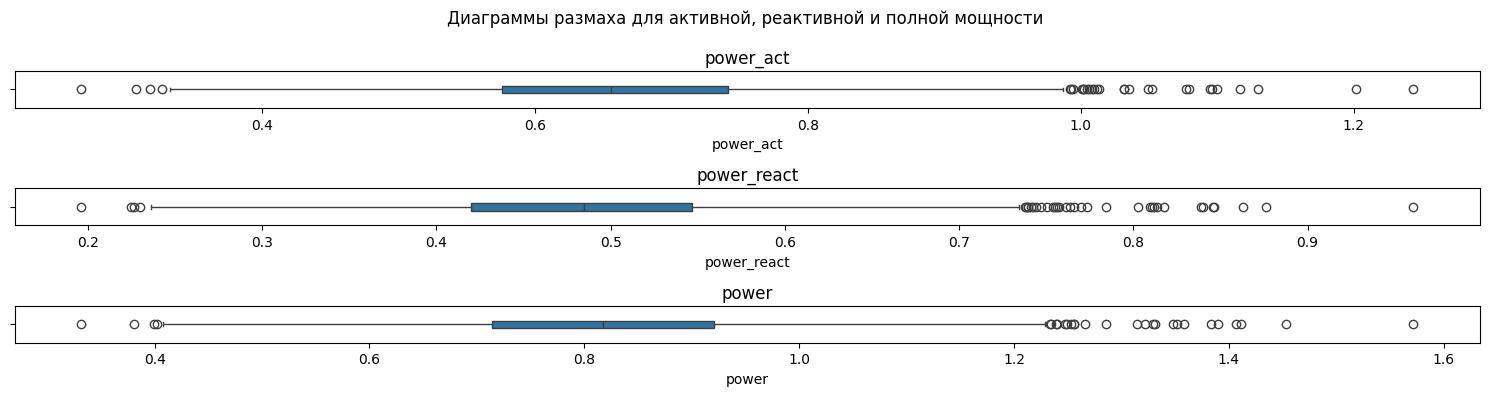

In [135]:
fig, axs = plt.subplots(3, 1, figsize=(15, 4))
fig.suptitle('Диаграммы размаха для активной, реактивной и полной мощности')

sns.boxplot (data = data_all['power_act'], ax=axs[0], width=0.2, orient='h')
sns.boxplot (data = data_all['power_react'], ax=axs[1], width=0.2, orient='h')
sns.boxplot (data = data_all['power'], ax=axs[2], width=0.2, orient='h')

axs[0].set_title('power_act')
axs[1].set_title('power_react')
axs[2].set_title('power')

plt.tight_layout()
plt.show()

Описательные статистики:

In [136]:
s = ['power_act', 'power_react', 'power']
data_all[s].describe()

,power_act,power_react,power
count,2329.000000,2329.000000,2329.000000
mean,0.664095,0.488897,0.824894
std,0.128350,0.097947,0.160188
min,0.267676,0.196228,0.331897
25%,0.576249,0.420051,0.713724
50%,0.655642,0.484690,0.817669
75%,0.741566,0.546490,0.920467
max,1.243889,0.960763,1.571727


Исследуем начальную температуру.

Построим гистограмму и диаграмму размаха.

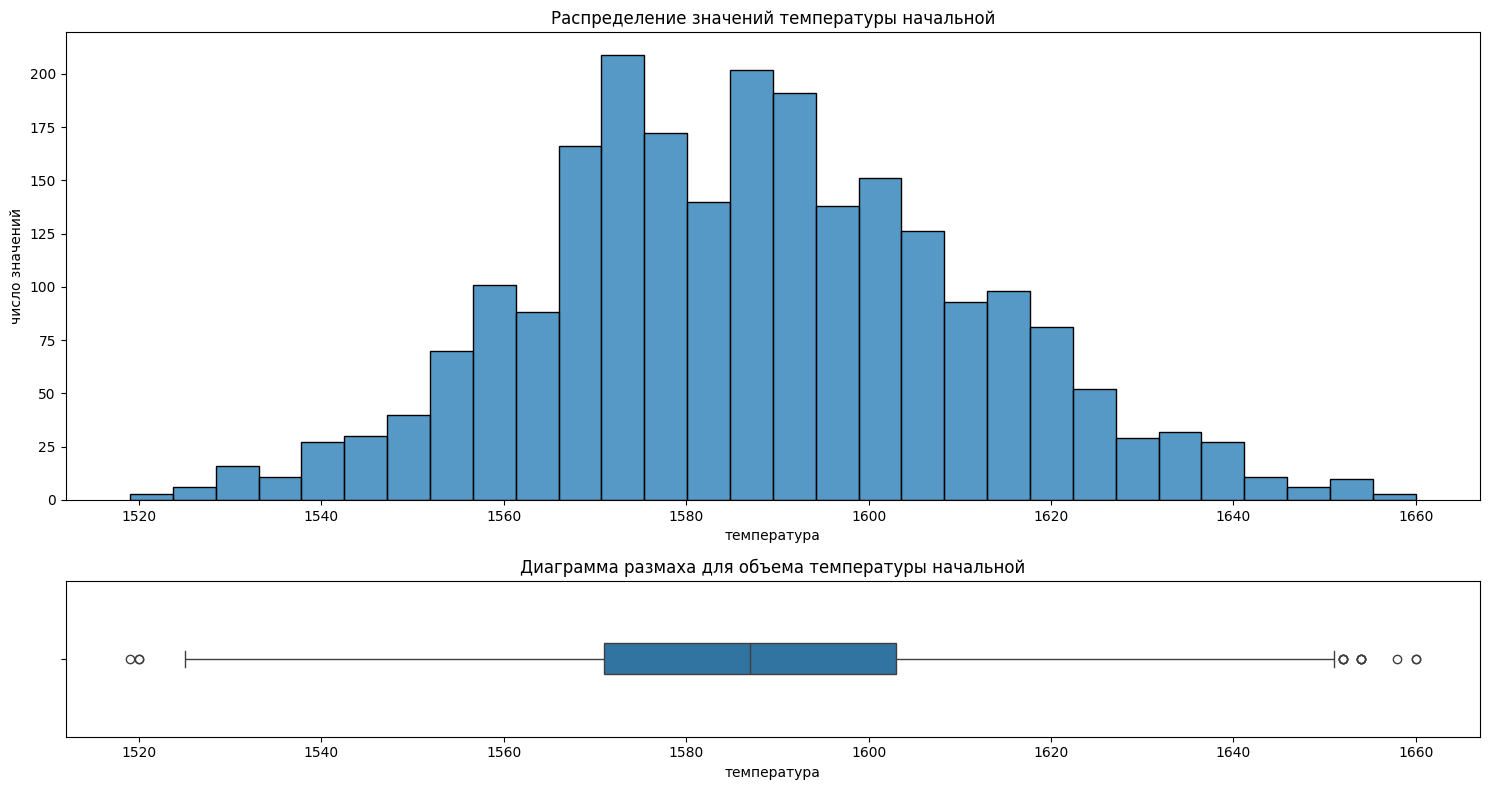

In [137]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

sns.histplot (data = data_all['temp_start'], ax=axs[0])

sns.boxplot (data = data_all['temp_start'],ax=axs[1], width=0.2, orient='h')

axs[0].set_ylabel('число значений')
axs[0].set_xlabel('температура')
axs[1].set_xlabel('температура')

axs[0].set_title('Распределение значений температуры начальной')
axs[1].set_title('Диаграмма размаха для объема температуры начальной')

plt.tight_layout()
plt.show()

Описательные статистики:

In [138]:
data_all['temp_start'].describe()

,temp_start
count,2329.000000
mean,1587.386003
std,23.619841
min,1519.000000
25%,1571.000000
50%,1587.000000
75%,1603.000000
max,1660.000000


 Теперь исследуем новый признак - время между первым и последним измерениями температуры в партии.

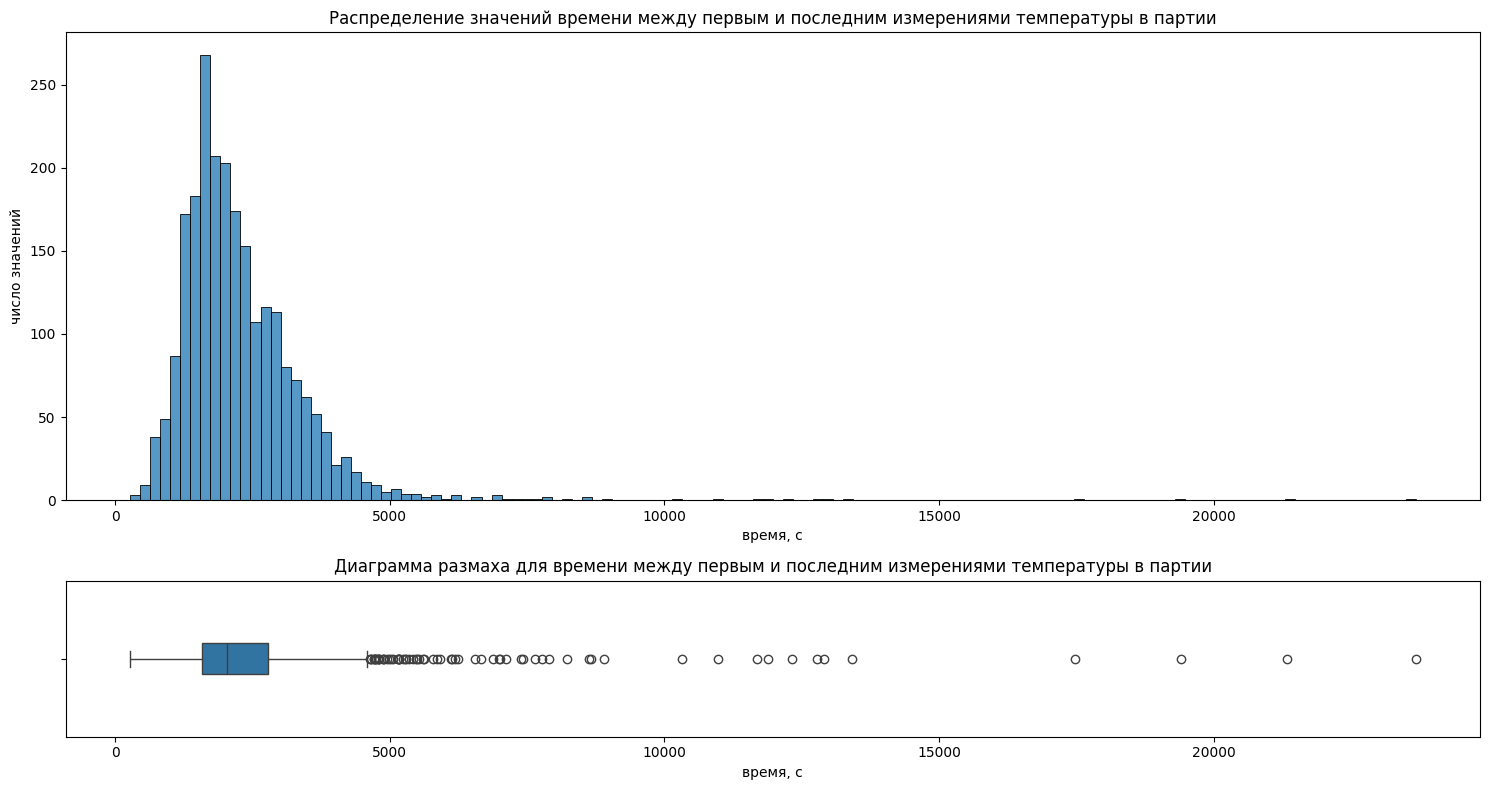

In [139]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

sns.histplot (data = data_all['time_between'], ax=axs[0])

sns.boxplot (data = data_all['time_between'],ax=axs[1], width=0.2, orient='h')

axs[0].set_ylabel('число значений')
axs[0].set_xlabel('время, с')
axs[1].set_xlabel('время, с')

axs[0].set_title('Распределение значений времени между первым и последним измерениями температуры в партии')
axs[1].set_title('Диаграмма размаха для времени между первым и последним измерениями температуры в партии')

plt.tight_layout()
plt.show()

In [140]:
data_all['time_between'].describe()

,time_between
count,2329.000000
mean,2321.810219
std,1385.191527
min,270.000000
25%,1579.000000
50%,2045.000000
75%,2791.000000
max,23674.000000


Последним рассмотрим распределение целевой переменной - конечной температуры.

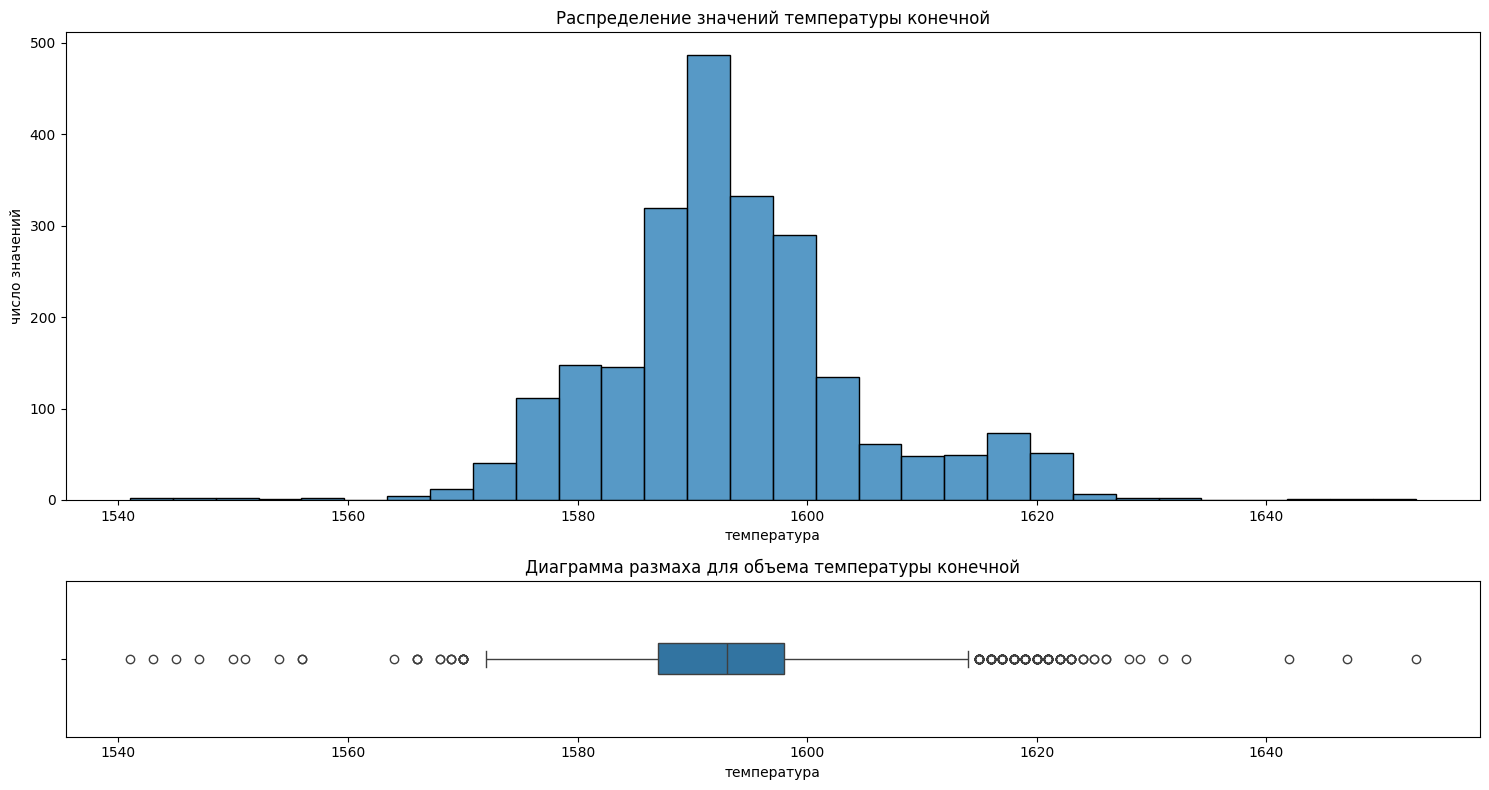

In [141]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

sns.histplot (data = data_all['temp_end'], bins = 30, ax=axs[0])

sns.boxplot (data = data_all['temp_end'], ax=axs[1], width=0.2, orient='h')

axs[0].set_ylabel('число значений')
axs[0].set_xlabel('температура')
axs[1].set_xlabel('температура')

axs[0].set_title('Распределение значений температуры конечной')
axs[1].set_title('Диаграмма размаха для объема температуры конечной')

plt.tight_layout()
plt.show()

In [142]:
data_all['temp_end'].describe()

,temp_end
count,2329.000000
mean,1593.365393
std,11.200915
min,1541.000000
25%,1587.000000
50%,1593.000000
75%,1598.000000
max,1653.000000


<b> Вывод по исследовательскому анализу объединенного датафрейма</b>

По сыпучим и проволочным веществам анализ повторяет тот, что делался по начальным таблицам, до объединения [п.2](#section2).

Теперь у нас появились новые признаки: время нагрева электродами, время между первым и последним измерением температуры и полная мощность.  Все они имеют распределение, близкое к нормальному, хотя во всех них содержится много выбросов.

Значения температуры теперь представляют два признака: начальная - входной, конечная - целевой.
Начальная температура имеет хорошее нормальное распределение, почти без выбросов, конечная  уже имеет гораздо больше выбросов.

Удалять выбросы не будем, поскольку мы не знаем, какие реальные значения могут принимать эти переменные. Требуется дополнительное исследование.  

### Корреляционный анализ объединенного датафрейма

Построим корреляционную матрицу для всех признаков объединенного датафрейма, все значения у нас числовые, метод расчета корреляций - коэффициенты Спирмена.

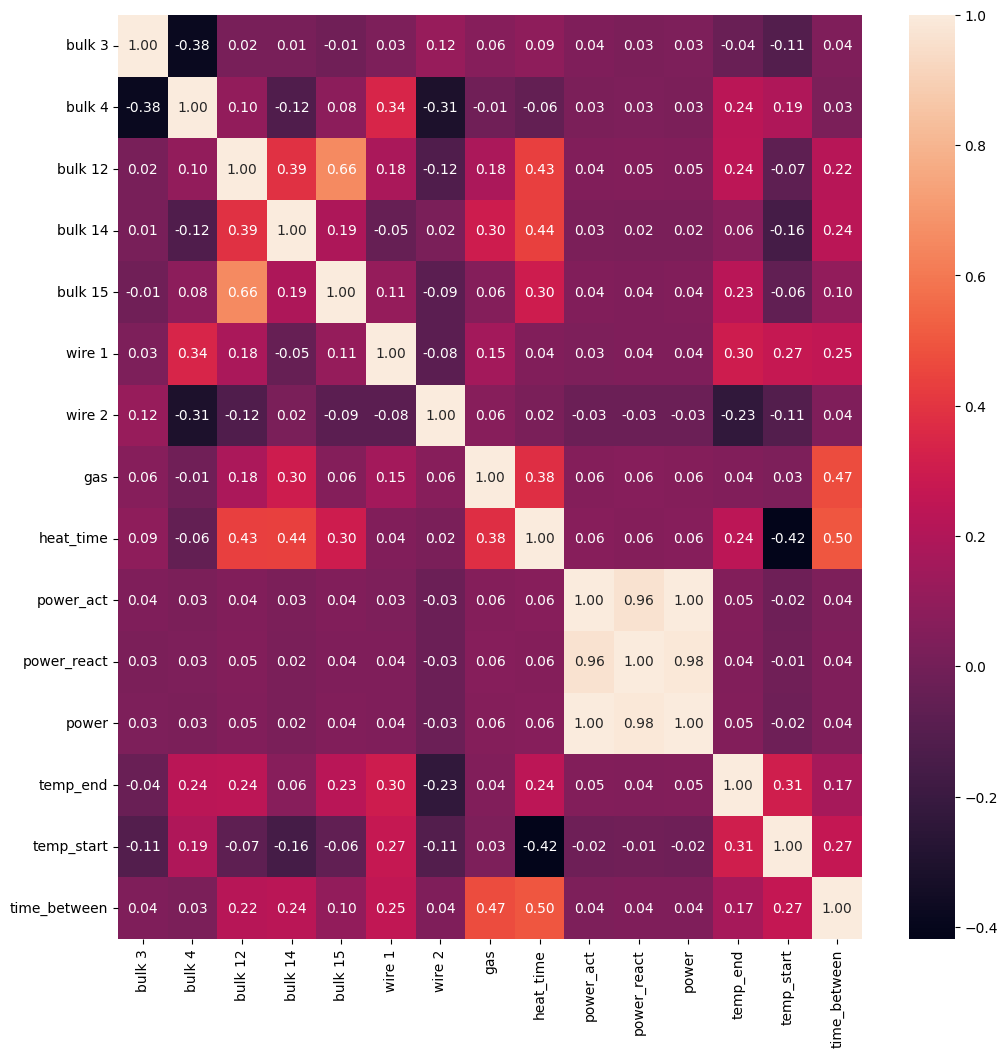

In [143]:
plt.figure(figsize=(12, 12))
sns.heatmap(data_all.corr(method='spearman'), annot=True, fmt='.2f')

plt.show()

<b> Вывод по корреляционному анализу</b>

Целевая переменная - конечная температура - имеет
- умеренную корреляцию по шкале Чеддока с wire 1 и температурой начальной (0.3 и 0.31 соответственно),
- слабую корреляцию с временем нагрева дугой (0.23), bulk 15 (0.22), bulk 12(0.23), bulk 4 (0.23) и временем между первым и последним замерами температуры.

Слабая обратная линейная связь наблюдается с wire 2 (-0.24).

С мощностями и остальными веществами нет корреляции.

В таблице мы наблюдаем сильную мультиколлинеарность у признаков мощности (0.96, 0.98 и 1). Поскольку при подборе модели мы будем использовать линейную регрессию, мультиколлинеарность сможет нам навредить, и из этих трех признаков мы оставим только один.

<a id='section5'></a>
##  Подготовка данных

Разделяем выборку на тренировочную и тестовую в пропорции 4:1.

Целевой признак: 'temp_end'.

Входные признаки: все из объединенной таблицы, кроме полной и реактивной мощности (их мы удаляем из-за мультиколлинеарности).

In [144]:
RANDOM_STATE = 70425
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    data_all.drop(
        ['temp_end','power_react','power'],
        axis=1
    ),
    data_all['temp_end'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)

In [145]:
display(X_train.head())

,bulk 3,bulk 4,bulk 12,bulk 14,bulk 15,wire 1,wire 2,gas,heat_time,power_act,temp_start,time_between
1550,220.0,0.0,283.0,208.0,211.0,100.198799,0.000000,11.065866,814.0,0.624398,1556.0,1845.0
671,220.0,0.0,205.0,153.0,155.0,165.391205,0.000000,9.337903,1169.0,0.740889,1610.0,2581.0
1266,64.0,0.0,206.0,104.0,105.0,98.092804,0.000000,8.285197,1003.0,0.814158,1571.0,2047.0
851,0.0,0.0,309.0,207.0,154.0,95.238007,40.142963,9.946897,772.0,0.487086,1591.0,3584.0
338,0.0,141.0,312.0,207.0,104.0,190.242004,0.000000,10.608407,844.0,0.556087,1584.0,2703.0


Выведем размеры тренировочной и тестовой выборок.

In [146]:
X_train.shape[0]

1746

In [147]:
X_test.shape[0]

583

Все признаки в задаче у нас числовые.

In [148]:
num_columns=X_train.columns

Для их масштабирования будем применять StandardScaler(), который пропишем в пайплайне для подготовки данных.

In [149]:
data_preprocessor = ColumnTransformer(
   transformers = [
      ('num', StandardScaler(), num_columns)
   ])

Поиск наилучшей модели будем проводить среди:
    
- линейной регрессии
    
- дерева решений для задачи регрессии DecisionTreeRegressor
    
- стохастического градиентного спуска SGDRegressor

- градиентного бустинга библиотеки CatBoostRegressor.

Словарь с гиперпараметрами моделей, которые мы будем перебирать:

In [150]:
param_distributions = [

    {
        'models': [LinearRegression()],
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_leaf': range(2, 10),
        'models__min_samples_split': range(2, 10),
        'select__k':range(1, 12),

    } ,

    {
        'models': [SGDRegressor(random_state=RANDOM_STATE)],
        'select__k':range(1, 12),

    } ,


      {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE,iterations=200,thread_count=-1,early_stopping_rounds=20)],
        'models__depth': [4,10],
        'select__k':range(1, 12),
    } ,
]

В словарь включен также перебор числа наилучших признаков методом SelectKBest c функцией оценки f_regression.

Итоговый пайплайн, включающий в себя подготовку данных, подбор наилучших признаков и модель.

In [151]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('select', SelectKBest(f_regression)),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

<a id='section6'></a>
##  Обучение моделей машинного обучения

Поиск наилучшей модели будем проводить случайным поиском по метрике МАЕ с кросс-валидацией на 5 выборках.

In [152]:
randomized_search_all = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_distributions,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=1000,
    cv=5
)

In [153]:
randomized_search_all.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 738 is smaller than n_iter=1000. Running 738 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Learning rate set to 0.165457
0:	learn: 10.9595649	total: 47.7ms	remaining: 9.5s
1:	learn: 10.5953902	total: 48.9ms	remaining: 4.84s
2:	learn: 10.2960134	total: 50ms	remaining: 3.28s
3:	learn: 10.1101844	total: 51.1ms	remaining: 2.5s
4:	learn: 9.8969552	total: 52.2ms	remaining: 2.03s
5:	learn: 9.6769664	total: 53.2ms	remaining: 1.72s
6:	learn: 9.5444446	total: 54.2ms	remaining: 1.49s
7:	learn: 9.3881073	total: 55.2ms	remaining: 1.32s
8:	learn: 9.2995774	total: 56.1ms	remaining: 1.19s
9:	learn: 9.1561931	total: 57.2ms	remaining: 1.09s
10:	learn: 9.0532279	total: 58.2ms	remaining: 1000ms
11:	learn: 8.9689691	total: 59.2ms	remaining: 927ms
12:	learn: 8.8609466	total: 60.2ms	remaining: 865ms
13:	learn: 8.7913358	total: 61.1ms	remaining: 812ms
14:	learn: 8.7207257	total: 62.1ms	remaining: 765ms
15:	learn: 8.6589171	total: 63ms	remaining: 725ms
16:	learn: 8.5906548	total: 64ms	remaining: 689ms
17:	learn: 8.5343692	total: 65ms	remaining: 658ms
18:	learn: 8.4870304	total: 66.1ms	remaining: 630

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               Index(['bulk 3', 'bulk 4', 'bulk 12', 'bulk 14', 'bulk 15', 'wire 1', 'wire 2',
       'gas', 'heat_time', 'power_act', 'temp_start', 'time_between'],
      dtype='object'))])),
                                             ('select',
                                              SelectKBest(score_func=<function f_regression at 0x78444b392c00>)),
                                             ('models'...
                                        {'models': [DecisionTreeRegressor(random_state=70425)],
                                         'models__min_samples_leaf': range(2, 10),
                                         'models__min_samples_split': range(2, 10),
                                         'select__k': range(1, 12)},
                                        {'models': [SGDRegressor(random_state=70425)],
                                         'select__k': range(1, 12)},
                                        {'models': [<catboost.core.CatBoostRegressor object at 0x78444a7f9bd0>],
                                         'models__depth': [4, 10],
                                         'select__k': range(1, 12)}],
                   random_state=70425, scoring='neg_mean_absolute_error')

Результаты поиска:

In [154]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(randomized_search_all.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score'))


,rank_test_score,param_models,mean_test_score,params
725,1,<catboost.core.CatBoostRegressor object at 0x78444a7f9bd0>,-6.063939,"{'select__k': 10, 'models__depth': 4, 'models': <catboost.core.CatBoostRegressor object at 0x78444a7f9bd0>}"
723,2,<catboost.core.CatBoostRegressor object at 0x78444a7f9bd0>,-6.075588,"{'select__k': 8, 'models__depth': 4, 'models': <catboost.core.CatBoostRegressor object at 0x78444a7f9bd0>}"
724,3,<catboost.core.CatBoostRegressor object at 0x78444a7f9bd0>,-6.091318,"{'select__k': 9, 'models__depth': 4, 'models': <catboost.core.CatBoostRegressor object at 0x78444a7f9bd0>}"
726,4,<catboost.core.CatBoostRegressor object at 0x78444a7f9bd0>,-6.130979,"{'select__k': 11, 'models__depth': 4, 'models': <catboost.core.CatBoostRegressor object at 0x78444a7f9bd0>}"
0,5,LinearRegression(),-6.197258,{'models': LinearRegression()}
...,...,...,...,...
46,734,DecisionTreeRegressor(random_state=70425),-10.042068,"{'select__k': 2, 'models__min_samples_split': 6, 'models__min_samples_leaf': 2, 'models': DecisionTreeRegressor(random_state=70425)}"
35,735,DecisionTreeRegressor(random_state=70425),-10.288417,"{'select__k': 2, 'models__min_samples_split': 5, 'models__min_samples_leaf': 2, 'models': DecisionTreeRegressor(random_state=70425)}"
24,736,DecisionTreeRegressor(random_state=70425),-10.346692,"{'select__k': 2, 'models__min_samples_split': 4, 'models__min_samples_leaf': 2, 'models': DecisionTreeRegressor(random_state=70425)}"
2,736,DecisionTreeRegressor(random_state=70425),-10.346692,"{'select__k': 2, 'models__min_samples_split': 2, 'models__min_samples_leaf': 2, 'models': DecisionTreeRegressor(random_state=70425)}"


Лучшей моделью стала CatBoostRegressor с глубиной дерева 4 и 10 наиболее важным признаками.

<a id='section7'></a>
##  Выбор лучшей модели

Теперь для лучшей модели посчитаем МАЕ на тестовой выборке.

In [155]:
best_model = randomized_search_all.best_estimator_

In [156]:
y_pred=best_model.predict(X_test)

In [157]:
mean_absolute_error(y_pred,y_test)

5.732461568238515

МАЕ на тестовой выборке 6.17.

Выведем еще коэффициент детерминации.

In [158]:
r2_score(y_test, y_pred)

0.44123536342103453

0.42 - не очень хорошее значение.

Положительные значения R² показывают, в скольких процентах случаев предсказание модели ближе к истине, чем среднее значение целевого признака. Чем ближе метрика к единице, тем лучше обобщающая способность модели и тем точнее будут предсказания. Поэтому наш результат нельзя считать хорошим.

Возможно, дело в распределении целевого признака: при среднем значении 1593 дисперсия равна всего 11.

R²=1-MSE/D, где D - дисперсия таргета, а MSE - гипотетическая суммарная ошибка, будто бы модель каждый раз предсказывает средние значения целевого признака.

Поэтому когда дисперсия относительно маленькая, дробь MSE/D принимает большие значения, а R² удаляется от 1.

Теперь сравним нашу модель с простейшей моделью, которая всегда предсказывает среднее выборки.

In [159]:
# создание и обучение модели DummyRegressor
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)

# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_test)

mean_absolute_error(dummy_model_preds,y_test)

7.432088832302805

Метрика МАЕ на тесте для модели DummyRegressor оказалась выше нашей, значит все-таки наша модель адекватна.

### Анализ важности признаков лучшей модели

Отбор признаков был произведен во время поиска наилучшей модели методом SelectKBest(f_regression).

Нам остается только вывести найденные признаки и построить диаграммы.

In [160]:
# выведем признаки, отобранные селектором
selected_features = [X_train.columns[i] for i, support
                     in enumerate(best_model.named_steps['select'].get_support()) if support]

display(selected_features)

['bulk 4',
 'bulk 12',
 'bulk 14',
 'bulk 15',
 'wire 1',
 'wire 2',
 'gas',
 'heat_time',
 'temp_start',
 'time_between']

In [161]:
# выведем результаты оценки каждого признака
pd.DataFrame(data={'score':best_model.named_steps['select'].scores_,
                   'support':best_model.named_steps['select'].get_support()},
             index=X_train.columns).sort_values(by='score',ascending=False)

,score,support
wire 1,222.356758,True
temp_start,204.654644,True
heat_time,167.287804,True
bulk 12,144.069240,True
bulk 15,137.786258,True
wire 2,80.089712,True
bulk 4,73.325718,True
time_between,43.609174,True
bulk 14,16.597731,True
gas,9.983544,True


SelectKBest выявил 10 наиболее важных признаков из 12.

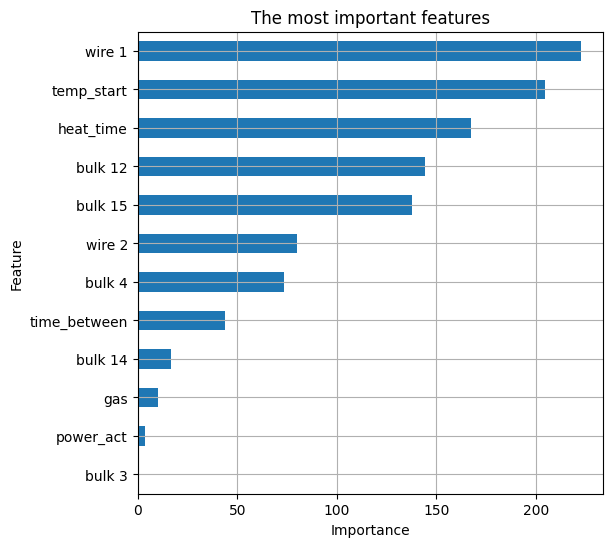

In [162]:
pd.DataFrame(data={'score':best_model.named_steps['select'].scores_,
                   'support':best_model.named_steps['select'].get_support()},
             index=X_train.columns).sort_values(by='score').plot(kind='barh', grid=True,
                                        figsize=(6,6), legend=False)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('The most important features')
plt.show()

<b> Вывод по анализу признаков</b>

SelectKBest выявил 10 наиболее важных признаков из 12.

Самыми важными оказались wire 1, начальная температура, bulk 12, время нагрева электродами, bulk 15, wire 2.

Заметим, что самыми важными признаками оказались те, которые показали наибольшую корреляцию с таргетом.

### Анализ остатков наилучшей модели

Анализ остатков модели проводится для того, чтобы оценить, насколько хорошо модель замечает взаимосвязи между признаками.

Считается, что модель хорошо справляется с задачей, если

1. остатки модели нормально распределены и их график симметричен относительно самого частого значения;

2. остатки имеют постоянную дисперсию на всём интервале использования модели.

Построим сначала на одном графике предсказанные и тестовые значения.

Добавим еще на график прямую y=x для более наглядного представления.

In [163]:
results = pd.DataFrame({
    'predictions': y_pred,
    'test': y_test
})

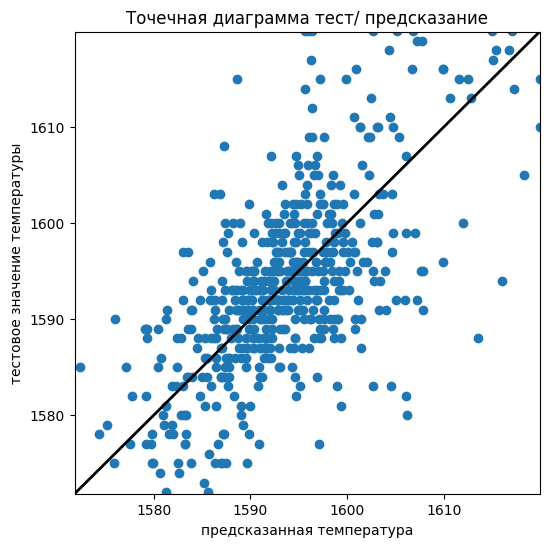

In [164]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter (data = results, x = 'predictions', y = 'test')

a=0
b=1

# границы отображения
lineStart=results['predictions'].min()
lineEnd=results['predictions'].max()

# построение прямой y=x
xseq = np.linspace(0, 10, num=100)
ax.plot([lineStart, lineEnd], [lineStart, lineEnd],xseq, a + b * xseq, color="k", lw=2)

plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)

plt.title('Точечная диаграмма тест/ предсказание')
plt.xlabel('предсказанная температура')
plt.ylabel('тестовое значение температуры')
plt.show()

На графике видны некоторые точечные выбросы, но в целом значения хорошо группируются вокруг линейной прямой.

Теперь построим гистограмму остатков и диаграмму рассеяния остатков и предсказаний. Дополнительно выведем описательныне статистики остатков.

count    583.000000
mean      -0.079342
std        7.910805
min      -47.907833
25%       -4.149821
50%       -0.012572
75%        4.362487
max       26.337855
Name: temp_end, dtype: float64


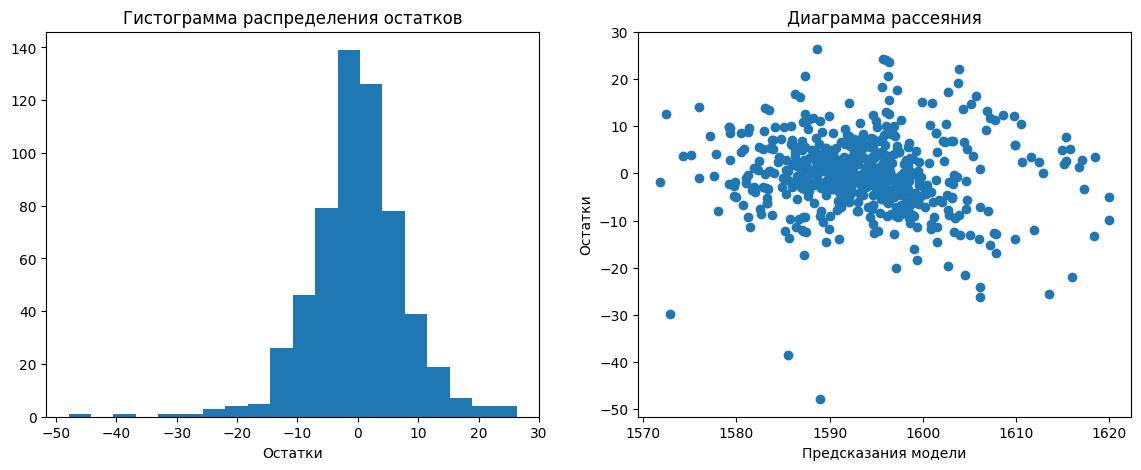

In [165]:
# остатки
residuals = y_test-y_pred

print(residuals.describe())

# построение гистограммы частотности и диаграммы рассеяния остатков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
axes[0].hist(residuals,bins=20)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=y_pred, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Диаграмма рассеяния')
plt.show()

Остатки в целом распределены симметрично относительно 0, среднее равно 0.6 - меньше 1 градуса.

По диаграмме рассеяния видно, что не считая нескольких выбросов, разброс остатков модели не сильно меняется для разных предсказаний.

Поэтому считаем, что модель в целом хорошо справляется с задачей предсказания

In [166]:
end=time.perf_counter()
elapsed =end - start  # Останавливаем таймер
print(f"Затрачено времени на выполнение: {elapsed} сек")

Затрачено времени на выполнение: 303.4000159039997 сек


<a id='section8'></a>
##  Общий вывод и рекомендации заказчику

Главной целью исследования было построение модели предсказания температуры сплава при обработке стали.

Работа включала в себя

- предобработку данных, в результате которой были устранены пропуски и аномальные значения,

- объединение исходных датасетов в один, создание новых признаков,

- исследовательский анализ признаков, в том числе корреляционный, для визуализации входных и целевого признака и нахождения взаимосвязей между ними,

- подготовку данных (разделение на выборки),

- выбор наилучшей модели случайным поиском с кросс-валидацией и подбором гиперпараметров среди линейной регрессии, DecisionTreeRegressor, GDRegressor и CatBoostRegressor

- сравнение с моделью DummyRegressor

- анализ лучших отобранных признаков

- анализ остатков наилучшей модели.

При поиске лучшей модели использовалась константа RANDOM_STATE = 70425.

Лучшей моделью оказалась CatBoostRegressor с глубиной дерева 4 и 10 наиболее важным признаками.

Метрика МАЕ на тесте 6.17, R² = 0.42.

Метрика удовлетворяет требованиям, поэтому задачу можно считать решенной.

Самыми важными признаками оказались:

wire 1, начальная температура, bulk 12, время нагрева электродами, bulk 15, wire 2.

Поэтому в качестве рекомендаций можно предложить воздействовать на эти признаки: подбирать экспериментально объемы перечисленных веществ, начальную температуру и время нагрева электродами, чтобы быстрее достигалась нужная температура.